In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
from matplotlib.lines import Line2D
import numpy as np

In [ ]:
class Args:
    def __init__(self, dataset, init_seed, alg, update_method, nbl, lagrangian_parameters, perso_method) -> None:
        self.dataset = dataset
        self.init_seed = init_seed
        self.alg = alg
        self.update_method = update_method
        self.nbl = nbl
        self.lagrangian_parameters = lagrangian_parameters
        self.perso_method = perso_method



clients_ids = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
update_methods = ['wb_diag', 'rkl', 'eaa']
personalization_methods = ['wb_diag', 'rkl']


init_seeds = ['0','1','2']
lagrangian_parameters = [1/4, 1/2, 1, 3/2, 2]
datasets = ['fmnist' , 'svhn', 'cifar10']
alg = 'BFLAVG'
base_dir = os.getcwd()
print(base_dir)
parent_dir = os.path.dirname(base_dir)
grandparent_dir = os.path.dirname(parent_dir)

/Users/nourjamoussi/Desktop/codes/BayesianFL/personalization


In [ ]:
# def merge_results(args):
#     # Define directories
#     dir = f'logs/ivon/{args.dataset}/{args.init_seed}'
#     experiment_dir = f'{dir}/{args.alg}/{args.update_method}'
#     results_dir = f'{experiment_dir}/results'

#     # Initialize an empty DataFrame to store all results
#     merged_data = pd.DataFrame()

#     # Helper function to read and append CSV files
#     def read_and_append_csv(folder, label):
#         nonlocal merged_data
#         folder_path = os.path.join(results_dir, folder)
#         if os.path.isfile(folder_path + '.csv'):
#             # If the path is a file, read it directly
#             df = pd.read_csv(folder_path + '.csv')
#             df['source'] = label
#             df['file'] = folder + '.csv'
#             df['file_number'] = 0  # Assign a default number for single files
#             merged_data = pd.concat([merged_data, df], ignore_index=True)
#         else:
#             # If the path is a directory, read all CSV files in it
#             for file_name in os.listdir(folder_path):
#                 if file_name.endswith('.csv'):
#                     file_path = os.path.join(folder_path, file_name)
#                     df = pd.read_csv(file_path)
#                     df['source'] = label
#                     df['file'] = file_name
#                     # Extract the number from the file name
#                     file_number = int(''.join(filter(str.isdigit, file_name)))
#                     df['file_number'] = file_number
#                     merged_data = pd.concat([merged_data, df], ignore_index=True)

#     # Read global model results
#     read_and_append_csv('global_on_local', 'global_on_local')
#     read_and_append_csv('local_on_global', 'local_on_global')
#     read_and_append_csv('global_on_global', 'global_on_global')
#     read_and_append_csv('local_on_local', 'local_on_local')

#     # Read personalized model results
#     for lam in args.lagrangian_parameters:
#         read_and_append_csv(f'personalized/{args.perso_method}/{lam}/perso_on_local', f'perso_on_local_lambda_{lam}')
#         read_and_append_csv(f'personalized/{args.perso_method}/{lam}/perso_on_global', f'perso_on_global_lambda_{lam}')

#     # Sort the merged data by source and file_number
#     merged_data.sort_values(by=['source', 'file_number'], inplace=True)

#     # Drop the file_number column as it's no longer needed
#     merged_data.drop(columns=['file_number'], inplace=True)

#     # Save the merged data to a new CSV file
#     merged_data.to_csv(os.path.join(f'{results_dir}/personalized/{args.perso_method}/', 'merged_results.csv'), index=False)



In [ ]:
# nbl = 0
# # merge the results of each experiment with the different models in one csv file 
# for dataset in datasets:
#     for update_method in update_methods:
#         for perso_method in personalization_methods:
#             for init_seed in init_seeds:
#                     args = Args(dataset, init_seed, alg, update_method, nbl, lagrangian_parameters, perso_method)
#                     merge_results(args)


# Effect of Lambda

In [ ]:

def extract_client_id(file_name):
    client_match = re.search(r'client_(\d+)', file_name)
    data_match = re.search(r'data_(\d+)', file_name)
    perso_match = re.search(r'perso_(\d+)', file_name)
    if client_match:
        return client_match.group(1)
    elif data_match:
        return data_match.group(1)
    elif perso_match:
        return perso_match.group(1)
    else:
        return None

def load_grouped_data(args, on_data):
    dfs = []
    for seed in range(3):
        dir = f'logs/ivon/{args.dataset}/{seed}'
        experiment_dir = f'{dir}/{args.alg}/{args.update_method}'
        results_dir = f'{experiment_dir}/results'
        path = f'{results_dir}/personalized/{args.perso_method}/merged_results.csv'
        if os.path.exists(path):
            df = pd.read_csv(path)
            df['seed'] = seed
            dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs)
    df['client_id'] = df['file'].apply(extract_client_id)
    #df = df.dropna(subset=['client_id'])

    perso_prefix = f'perso_on_{on_data}_lambda_'
    global_source = 'global_on_local' if on_data == 'local' else 'global_on_global'
    local_source = 'local_on_local' if on_data == 'local' else 'local_on_global'

    df_perso = df[df['source'].str.startswith(perso_prefix)].copy()
    df_perso['lambda'] = df_perso['source'].str.extract(r'lambda_([0-9.]+)').astype(float)

    df_local = df[df['source'] == local_source].copy()
    df_local['lambda'] = 3.0

    df_global_lambda0 = pd.DataFrame()
    if on_data == 'local':
        df_global_lambda0 = df[df['source'] == 'global_on_local'].copy()
        df_global_lambda0['lambda'] = 0.0
    elif on_data == 'global':
        df_global_raw = df[df['source'] == 'global_on_global'].copy()
        if not df_global_raw.empty:
            df_global_lambda0 = df_global_raw.copy()
            df_global_lambda0['lambda'] = 0.0
            df_global_lambda0['client_id'] = df_global_lambda0['client_id'].fillna('global')  # single point

    full_df = pd.concat([df_global_lambda0, df_perso, df_local], ignore_index=True)
    full_df['lambda'] = full_df['lambda'].astype(float)
    #full_df['ECE'] /= 100.0
    return full_df

In [3]:
def plot_combined_dual_axis(args):
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.size'] = 12

    metrics = ['Acc', 'ECE', 'NLL']
    metric_labels = {
        'Acc': 'Accuracy',
        'ECE': 'ECE',
        'NLL': 'NLL'
    }
    datasets_label = {
        'fmnist': 'FMNIST',
        'svhn': 'SVHN',
        'cifar10': 'CIFAR-10'}

    df_local = load_grouped_data(args, 'local')
    df_global = load_grouped_data(args, 'global')
    if df_local is None or df_global is None:
        print(f"Missing data for {args.dataset}  and {args.update_method} and {args.perso_method}.")
        print("Missing data.")
        return

    grouped_local = df_local.groupby(['lambda', 'client_id'])[metrics].mean().reset_index()
    grouped_global = df_global.groupby(['lambda', 'client_id'])[metrics].mean().reset_index()

    lambda_order = sorted(set(grouped_local['lambda'].unique()).union(grouped_global['lambda'].unique()))
    lambda_labels = [r'$' + ('\infty' if l == 3.0 else str(l)) + r'$' for l in lambda_order]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

    for ax, metric in zip(axes, metrics):
        scatter_local = scatter_global = line_local = line_global = None

        for l in lambda_order:
            jitter = 0.04
            x_local = l - jitter
            x_global = l + jitter
            local_vals = grouped_local[grouped_local['lambda'] == l][metric].values
            global_vals = grouped_global[grouped_global['lambda'] == l][metric].values
            if len(local_vals) > 0:
                scatter_local = ax.scatter([x_local] * len(local_vals), local_vals, color='blue', alpha=0.6, s=20)
            if len(global_vals) > 0:
                scatter_global = ax.scatter([x_global] * len(global_vals), global_vals, color='red', alpha=0.6, s=20)

        stats_local = grouped_local.groupby('lambda')[metric].agg(['mean', 'std']).reindex(lambda_order).reset_index()
        stats_global = grouped_global.groupby('lambda')[metric].agg(['mean', 'std']).reindex(lambda_order).reset_index()

        line_local = ax.errorbar(lambda_order, stats_local['mean'], yerr=stats_local['std'], fmt='-o', color='blue')
        line_global = ax.errorbar(lambda_order, stats_global['mean'], yerr=stats_global['std'], fmt='-s', color='red')

        # Set shared y-axis limits
        all_vals = np.concatenate([grouped_local[metric].values, grouped_global[metric].values])
        ymin, ymax = np.min(all_vals), np.max(all_vals)
        padding = (ymax - ymin) * 0.1
        ax.set_ylim([ymin - padding, ymax + padding])

        ax.set_ylabel(f'{metric_labels[metric]}', fontsize=20)
        ax.grid(True)

    for ax in axes:
        ax.set_xticks(lambda_order)
        ax.set_xticklabels(lambda_labels, fontsize=14)
        ax.set_xlabel(r'$\lambda$', fontsize=20)
        ax.set_facecolor('none')   # Transparent axes background


    # Custom legend
    custom_lines = [
        Line2D([0], [0], marker='s', color='blue', lw=2, label='Average performance on Local data'),
        Line2D([0], [0], marker='s', color='red', lw=2, label='Average performance on Global data'),
        Line2D([0], [0], marker='o', color='blue', linestyle='', alpha=0.6, label='Clients performance on Local data'),
        Line2D([0], [0], marker='o', color='red', linestyle='', alpha=0.6, label='Clients performance on Global data')
    ]
    #fig.legend(handles=custom_lines, loc='upper center', ncol=2, frameon=False)
    fig.legend(handles=custom_lines, loc='upper center', ncol=4, frameon=False, fontsize=16)


    fig.tight_layout(rect=[0, 0, 1, 0.93])
    #fig.suptitle(f'Results on Local vs Global Data — {datasets_label[args.dataset]} - Personalization {args.perso_method} - Global Update {args.update_method}', fontsize=16)

    # Remove background
    fig.patch.set_alpha(0.0)   # Transparent figure background


    outdir = f'figs/{args.dataset}/{args.alg}/{args.update_method}/{args.nbl}/{args.perso_method}'
    os.makedirs(outdir, exist_ok=True)
    fname = f'{outdir}/{datasets_label[args.dataset]} - Personalization {args.perso_method} - Global Update {args.update_method}'
    fig.savefig(f'{fname}.pdf', bbox_inches='tight')
    fig.savefig(f'{fname}.png', bbox_inches='tight')
    plt.close()


In [ ]:
nbl = 0
init_seed = '0' #used only to define the args, the plots consider all the seeds with mean and std
for dataset in datasets:
    for update_method in update_methods:
        for perso_method in personalization_methods:
                args = Args(dataset, init_seed, alg, update_method, nbl, lagrangian_parameters, perso_method)
                plot_combined_dual_axis(args)

# Table of results

## Ours

In [15]:
def generate_metric_summary_table(df, target_lambda):
    # Filter for the specific lambda
    df_lambda = df[df['lambda'] == target_lambda]
    # Group by source (local_on_local, global_on_local, etc.)
    grouped = df_lambda.groupby('source')[['Acc', 'ECE', 'NLL']].agg(['mean', 'std'])
    # Flatten multi-index columns
    grouped.columns = [f'{metric} ({stat})' for metric, stat in grouped.columns]
    grouped.reset_index(inplace=True)

    return grouped

#### Local

In [27]:
# For the resulst table: 
args = Args('fmnist', '0', 'BFLAVG', 'wb_diag', '0', lagrangian_parameters, 'wb_diag')
df_fmnist_wb_local = load_grouped_data(args, 'local')
df_fmnist_wb_local
generate_metric_summary_table(df_fmnist_wb_local, 1.0)
print(generate_metric_summary_table(df_fmnist_wb_local, 1.0).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 & source & Acc (mean) & Acc (std) & ECE (mean) & ECE (std) & NLL (mean) & NLL (std) \\
\midrule
0 & perso_on_local_lambda_1 & 92.22 & 3.23 & 0.06 & 0.02 & 0.34 & 0.14 \\
\bottomrule
\end{tabular}



In [28]:
# For the resulst table: 
args = Args('fmnist', '0', 'BFLAVG', 'wb_diag', '0', lagrangian_parameters, 'wb_diag')
df_fmnist_wb_local = load_grouped_data(args, 'local')
df_fmnist_wb_local
generate_metric_summary_table(df_fmnist_wb_local, 0)
print(generate_metric_summary_table(df_fmnist_wb_local, 0).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 & source & Acc (mean) & Acc (std) & ECE (mean) & ECE (std) & NLL (mean) & NLL (std) \\
\midrule
0 & global_on_local & 88.45 & 4.88 & 0.08 & 0.03 & 0.47 & 0.20 \\
\bottomrule
\end{tabular}



In [29]:
# For the resulst table: 
args = Args('svhn', '0', 'BFLAVG', 'wb_diag', '0', lagrangian_parameters, 'wb_diag')
df_svhn_wb_local = load_grouped_data(args, 'local')
df_svhn_wb_local
generate_metric_summary_table(df_svhn_wb_local, 1.0)
print(generate_metric_summary_table(df_svhn_wb_local, 1.0).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 & source & Acc (mean) & Acc (std) & ECE (mean) & ECE (std) & NLL (mean) & NLL (std) \\
\midrule
0 & perso_on_local_lambda_1 & 91.87 & 3.03 & 0.05 & 0.02 & 0.40 & 0.14 \\
\bottomrule
\end{tabular}



In [30]:
# For the resulst table: 
args = Args('svhn', '0', 'BFLAVG', 'wb_diag', '0', lagrangian_parameters, 'wb_diag')
df_svhn_wb_local = load_grouped_data(args, 'local')
df_svhn_wb_local
generate_metric_summary_table(df_svhn_wb_local, 0)
print(generate_metric_summary_table(df_svhn_wb_local, 0).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 & source & Acc (mean) & Acc (std) & ECE (mean) & ECE (std) & NLL (mean) & NLL (std) \\
\midrule
0 & global_on_local & 87.18 & 4.63 & 0.07 & 0.03 & 0.58 & 0.20 \\
\bottomrule
\end{tabular}



In [31]:
# For the resulst table: 
args = Args('cifar10', '0', 'BFLAVG', 'wb_diag', '0', lagrangian_parameters, 'wb_diag')
df_cifar10_wb_local = load_grouped_data(args, 'local')
df_cifar10_wb_local
generate_metric_summary_table(df_cifar10_wb_local, 1.0)
print(generate_metric_summary_table(df_cifar10_wb_local, 1.0).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 & source & Acc (mean) & Acc (std) & ECE (mean) & ECE (std) & NLL (mean) & NLL (std) \\
\midrule
0 & perso_on_local_lambda_1 & 76.82 & 4.01 & 0.08 & 0.01 & 0.66 & 0.10 \\
\bottomrule
\end{tabular}



In [32]:
# For the resulst table: 
args = Args('cifar10', '0', 'BFLAVG', 'wb_diag', '0', lagrangian_parameters, 'wb_diag')
df_cifar10_wb_local = load_grouped_data(args, 'local')
df_cifar10_wb_local
generate_metric_summary_table(df_cifar10_wb_local, 0)
print(generate_metric_summary_table(df_cifar10_wb_local, 0).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 & source & Acc (mean) & Acc (std) & ECE (mean) & ECE (std) & NLL (mean) & NLL (std) \\
\midrule
0 & global_on_local & 65.39 & 6.74 & 0.11 & 0.02 & 0.99 & 0.18 \\
\bottomrule
\end{tabular}



### Global

In [65]:
# For the resulst table: 
args = Args('fmnist', '0', 'BFLAVG', 'wb_diag', '0', lagrangian_parameters, 'wb_diag')
df_fmnist_wb_global = load_grouped_data(args, 'global')
df_fmnist_wb_global
generate_metric_summary_table(df_fmnist_wb_global, 1.0)
print(generate_metric_summary_table(df_fmnist_wb_global, 1.0).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 & source & Acc (mean) & Acc (std) & ECE (mean) & ECE (std) & NLL (mean) & NLL (std) \\
\midrule
0 & perso_on_global_lambda_1 & 84.61 & 3.41 & 0.11 & 0.03 & 0.73 & 0.18 \\
\bottomrule
\end{tabular}



In [35]:
# For the resulst table: 
args = Args('fmnist', '0', 'BFLAVG', 'wb_diag', '0', lagrangian_parameters, 'wb_diag')
df_fmnist_wb_global = load_grouped_data(args, 'global')
df_fmnist_wb_global
generate_metric_summary_table(df_fmnist_wb_global, 0)
print(generate_metric_summary_table(df_fmnist_wb_global, 0).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 & source & Acc (mean) & Acc (std) & ECE (mean) & ECE (std) & NLL (mean) & NLL (std) \\
\midrule
0 & global_on_global & 88.14 & 0.60 & 0.07 & 0.00 & 0.49 & 0.02 \\
\bottomrule
\end{tabular}



In [36]:
# For the resulst table: 
args = Args('svhn', '0', 'BFLAVG', 'wb_diag', '0', lagrangian_parameters, 'wb_diag')
df_svhn_wb_global = load_grouped_data(args, 'global')
df_svhn_wb_global
generate_metric_summary_table(df_svhn_wb_global, 1.0)
print(generate_metric_summary_table(df_svhn_wb_global, 1.0).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 & source & Acc (mean) & Acc (std) & ECE (mean) & ECE (std) & NLL (mean) & NLL (std) \\
\midrule
0 & perso_on_global_lambda_1 & 79.87 & 5.21 & 0.12 & 0.04 & 1.00 & 0.31 \\
\bottomrule
\end{tabular}



In [37]:
# For the resulst table: 
args = Args('svhn', '0', 'BFLAVG', 'wb_diag', '0', lagrangian_parameters, 'wb_diag')
df_svhn_wb_global = load_grouped_data(args, 'global')
df_svhn_wb_global
generate_metric_summary_table(df_svhn_wb_global, 0)
print(generate_metric_summary_table(df_svhn_wb_global, 0).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 & source & Acc (mean) & Acc (std) & ECE (mean) & ECE (std) & NLL (mean) & NLL (std) \\
\midrule
0 & global_on_global & 86.54 & 1.05 & 0.06 & 0.01 & 0.60 & 0.06 \\
\bottomrule
\end{tabular}



In [38]:
# For the resulst table: 
args = Args('cifar10', '0', 'BFLAVG', 'wb_diag', '0', lagrangian_parameters, 'wb_diag')
df_cifar10_wb_global = load_grouped_data(args, 'global')
df_cifar10_wb_global
generate_metric_summary_table(df_cifar10_wb_global, 1.0)
print(generate_metric_summary_table(df_cifar10_wb_global, 1.0).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 & source & Acc (mean) & Acc (std) & ECE (mean) & ECE (std) & NLL (mean) & NLL (std) \\
\midrule
0 & perso_on_global_lambda_1 & 57.75 & 6.98 & 0.15 & 0.07 & 1.38 & 0.33 \\
\bottomrule
\end{tabular}



In [39]:
# For the resulst table: 
args = Args('cifar10', '0', 'BFLAVG', 'wb_diag', '0', lagrangian_parameters, 'wb_diag')
df_cifar10_wb_global = load_grouped_data(args, 'global')
df_cifar10_wb_global
generate_metric_summary_table(df_cifar10_wb_global, 0)
print(generate_metric_summary_table(df_cifar10_wb_global, 0).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 & source & Acc (mean) & Acc (std) & ECE (mean) & ECE (std) & NLL (mean) & NLL (std) \\
\midrule
0 & global_on_global & 65.05 & 3.57 & 0.06 & 0.01 & 0.99 & 0.09 \\
\bottomrule
\end{tabular}



## FedAVG

In [ ]:
def load_grouped_data_fedavg(args, on_data):
    dfs = []
    for seed in range(3):
        dir = f'logs/{args.dataset}/{seed}'
        experiment_dir = f'{dir}/{args.alg}'
        results_dir = f'{experiment_dir}/results'
        path = f'{results_dir}/personalized/{args.perso_method}/merged_results.csv'
        if os.path.exists(path):
            df = pd.read_csv(path)
            df['seed'] = seed
            dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs)
    df['client_id'] = df['file'].apply(extract_client_id)
    #df = df.dropna(subset=['client_id'])

    perso_prefix = f'perso_on_{on_data}_lambda_'
    global_source = 'global_on_local' if on_data == 'local' else 'global_on_global'
    local_source = 'local_on_local' if on_data == 'local' else 'local_on_global'

    df_perso = df[df['source'].str.startswith(perso_prefix)].copy()
    df_perso['lambda'] = df_perso['source'].str.extract(r'lambda_([0-9.]+)').astype(float)

    df_local = df[df['source'] == local_source].copy()
    df_local['lambda'] = 3.0

    df_global_lambda0 = pd.DataFrame()
    if on_data == 'local':
        df_global_lambda0 = df[df['source'] == 'global_on_local'].copy()
        df_global_lambda0['lambda'] = 0.0
    elif on_data == 'global':
        df_global_raw = df[df['source'] == 'global_on_global'].copy()
        if not df_global_raw.empty:
            df_global_lambda0 = df_global_raw.copy()
            df_global_lambda0['lambda'] = 0.0
            df_global_lambda0['client_id'] = df_global_lambda0['client_id'].fillna('global')  # single point

    full_df = pd.concat([df_global_lambda0, df_perso, df_local], ignore_index=True)
    full_df['lambda'] = full_df['lambda'].astype(float)
    #full_df['ECE'] /= 100.0
    return full_df

### Local

In [75]:
# For the resulst table: 
args = Args('fmnist', '0', 'FedAVG', 'none', '0', lagrangian_parameters, 'none')
df_fmnist_local = load_grouped_data_fedavg(args, 'local')
generate_metric_summary_table(df_fmnist_local, 3.0)
print(generate_metric_summary_table(df_fmnist_local, 3.0).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 & source & Acc (mean) & Acc (std) & ECE (mean) & ECE (std) & NLL (mean) & NLL (std) \\
\midrule
0 & local_on_local & 92.28 & 3.16 & 0.07 & 0.03 & 0.56 & 0.26 \\
\bottomrule
\end{tabular}



In [76]:
# For the resulst table: 
args = Args('svhn', '0', 'FedAVG', 'none', '0', lagrangian_parameters, 'none')
df_svhn_local = load_grouped_data_fedavg(args, 'local')
generate_metric_summary_table(df_svhn_local, 3.0)
print(generate_metric_summary_table(df_svhn_local, 3.0).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 & source & Acc (mean) & Acc (std) & ECE (mean) & ECE (std) & NLL (mean) & NLL (std) \\
\midrule
0 & local_on_local & 91.17 & 3.38 & 0.08 & 0.03 & 0.74 & 0.29 \\
\bottomrule
\end{tabular}



In [77]:
# For the resulst table: 
args = Args('cifar10', '0', 'FedAVG', 'none', '0', lagrangian_parameters, 'none')
df_cifar10_local = load_grouped_data_fedavg(args, 'local')
generate_metric_summary_table(df_cifar10_local, 3.0)
print(generate_metric_summary_table(df_cifar10_local, 3.0).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 & source & Acc (mean) & Acc (std) & ECE (mean) & ECE (std) & NLL (mean) & NLL (std) \\
\midrule
0 & local_on_local & 74.80 & 4.89 & 0.13 & 0.02 & 0.91 & 0.16 \\
\bottomrule
\end{tabular}



In [81]:
# For the resulst table: 
args = Args('fmnist', '0', 'FedAVG', 'none', '0', lagrangian_parameters, 'none')
df_fmnist_local = load_grouped_data_fedavg(args, 'local')
generate_metric_summary_table(df_fmnist_local, 0)
print(generate_metric_summary_table(df_fmnist_local, 0).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 & source & Acc (mean) & Acc (std) & ECE (mean) & ECE (std) & NLL (mean) & NLL (std) \\
\midrule
0 & global_on_local & 87.89 & 4.83 & 0.10 & 0.04 & 0.73 & 0.29 \\
\bottomrule
\end{tabular}



In [82]:
# For the resulst table: 
args = Args('svhn', '0', 'FedAVG', 'none', '0', lagrangian_parameters, 'none')
df_svhn_local = load_grouped_data_fedavg(args, 'local')
generate_metric_summary_table(df_svhn_local, 0)
print(generate_metric_summary_table(df_svhn_local, 0).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 & source & Acc (mean) & Acc (std) & ECE (mean) & ECE (std) & NLL (mean) & NLL (std) \\
\midrule
0 & global_on_local & 86.62 & 3.97 & 0.11 & 0.03 & 0.98 & 0.31 \\
\bottomrule
\end{tabular}



In [83]:
# For the resulst table: 
args = Args('cifar10', '0', 'FedAVG', 'none', '0', lagrangian_parameters, 'none')
df_cifar10_local = load_grouped_data_fedavg(args, 'local')
generate_metric_summary_table(df_cifar10_local, 0)
print(generate_metric_summary_table(df_cifar10_local, 0).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 & source & Acc (mean) & Acc (std) & ECE (mean) & ECE (std) & NLL (mean) & NLL (std) \\
\midrule
0 & global_on_local & 61.24 & 7.67 & 0.16 & 0.05 & 1.20 & 0.25 \\
\bottomrule
\end{tabular}



### Global

In [78]:
# For the resulst table: 
args = Args('fmnist', '0', 'FedAVG', 'none', '0', lagrangian_parameters, 'none')
df_fmnist_global = load_grouped_data_fedavg(args, 'global')
generate_metric_summary_table(df_fmnist_global, 3.0)
print(generate_metric_summary_table(df_fmnist_global, 3.0).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 & source & Acc (mean) & Acc (std) & ECE (mean) & ECE (std) & NLL (mean) & NLL (std) \\
\midrule
0 & local_on_global & 79.12 & 5.56 & 0.18 & 0.05 & 1.80 & 0.68 \\
\bottomrule
\end{tabular}



In [79]:
# For the resulst table: 
args = Args('svhn', '0', 'FedAVG', 'none', '0', lagrangian_parameters, 'none')
df_svhn_global = load_grouped_data_fedavg(args, 'global')
generate_metric_summary_table(df_svhn_global, 3.0)
print(generate_metric_summary_table(df_svhn_global, 3.0).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 & source & Acc (mean) & Acc (std) & ECE (mean) & ECE (std) & NLL (mean) & NLL (std) \\
\midrule
0 & local_on_global & 68.67 & 8.54 & 0.27 & 0.08 & 3.11 & 1.13 \\
\bottomrule
\end{tabular}



In [80]:
# For the resulst table: 
args = Args('cifar10', '0', 'FedAVG', 'none', '0', lagrangian_parameters, 'none')
df_cifar10_global = load_grouped_data_fedavg(args, 'global')
generate_metric_summary_table(df_cifar10_global, 3.0)
print(generate_metric_summary_table(df_cifar10_global, 3.0).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 & source & Acc (mean) & Acc (std) & ECE (mean) & ECE (std) & NLL (mean) & NLL (std) \\
\midrule
0 & local_on_global & 45.89 & 6.78 & 0.36 & 0.07 & 3.65 & 1.24 \\
\bottomrule
\end{tabular}



In [84]:
# For the resulst table: 
args = Args('fmnist', '0', 'FedAVG', 'none', '0', lagrangian_parameters, 'none')
df_fmnist_global = load_grouped_data_fedavg(args, 'global')
generate_metric_summary_table(df_fmnist_global, 0)
print(generate_metric_summary_table(df_fmnist_global, 0).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 & source & Acc (mean) & Acc (std) & ECE (mean) & ECE (std) & NLL (mean) & NLL (std) \\
\midrule
0 & global_on_global & 87.88 & 0.97 & 0.09 & 0.01 & 0.76 & 0.05 \\
\bottomrule
\end{tabular}



In [85]:
# For the resulst table: 
args = Args('svhn', '0', 'FedAVG', 'none', '0', lagrangian_parameters, 'none')
df_svhn_global = load_grouped_data_fedavg(args, 'global')
generate_metric_summary_table(df_svhn_global, 0)
print(generate_metric_summary_table(df_svhn_global, 0).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 & source & Acc (mean) & Acc (std) & ECE (mean) & ECE (std) & NLL (mean) & NLL (std) \\
\midrule
0 & global_on_global & 86.06 & 0.55 & 0.11 & 0.01 & 1.01 & 0.07 \\
\bottomrule
\end{tabular}



In [86]:
# For the resulst table: 
args = Args('cifar10', '0', 'FedAVG', 'none', '0', lagrangian_parameters, 'none')
df_cifar10_global = load_grouped_data_fedavg(args, 'global')
generate_metric_summary_table(df_cifar10_global, 0)
print(generate_metric_summary_table(df_cifar10_global, 0).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 & source & Acc (mean) & Acc (std) & ECE (mean) & ECE (std) & NLL (mean) & NLL (std) \\
\midrule
0 & global_on_global & 61.63 & 3.81 & 0.12 & 0.03 & 1.18 & 0.13 \\
\bottomrule
\end{tabular}



## Capfl

### Fmnist

In [3]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/capfl/capfl_fmnist_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 99]
    #print(df)
    df_loc_on_loc = df[df['Client'] == df['Dataset']]
    df_loc_on_loc = df_loc_on_loc[df_loc_on_loc['Client'] !='G']
    #print(df_loc_on_loc)
    acc_loc_on_loc = df_loc_on_loc['ACC'].mean()
    ece_loc_on_loc = df_loc_on_loc['ECE'].mean()/100
    nll_loc_on_loc = df_loc_on_loc['NLL'].mean()
    acc_loc_on_loc_std = df_loc_on_loc['ACC'].std()
    ece_loc_on_loc_std = (df_loc_on_loc['ECE']/100).std()
    nll_loc_on_loc_std = df_loc_on_loc['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Local on Local)': acc_loc_on_loc,
        'ACC (Local on Local) std': acc_loc_on_loc_std,
        'ECE (Local on Local)': ece_loc_on_loc,
        'ECE (Local on Local) std': ece_loc_on_loc_std,
        'NLL (Local on Local)': nll_loc_on_loc,
        'NLL (Local on Local) std': nll_loc_on_loc_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


                            File  ACC (Local on Local)  \
0  logs/capfl/capfl_fmnist_2.csv             92.986716   
1  logs/capfl/capfl_fmnist_0.csv             93.302699   
2  logs/capfl/capfl_fmnist_1.csv             92.709189   

   ACC (Local on Local) std  ECE (Local on Local)  ECE (Local on Local) std  \
0                  1.979316              0.059123                  0.014422   
1                  3.416373              0.054309                  0.023584   
2                  2.991453              0.061875                  0.024862   

   NLL (Local on Local)  NLL (Local on Local) std  
0              0.344113                  0.098101  
1              0.306984                  0.147735  
2              0.379133                  0.168641  
ACC (Local on Local): 93.00
ACC (Local on Local) std: 2.80
ECE (Local on Local): 0.06
ECE (Local on Local) std: 0.02
NLL (Local on Local): 0.34
NLL (Local on Local) std: 0.14


In [1]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/capfl/capfl_fmnist_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 99]
    #print(df)
    df_loc_on_g = df[df['Client'] != 'G']
    df_loc_on_g = df_loc_on_g[df_loc_on_g['Dataset'] == 'G']
    #print(df_loc_on_g)
    acc_loc_on_glob = df_loc_on_g['ACC'].mean()
    ece_loc_on_glob = df_loc_on_g['ECE'].mean()/100
    nll_loc_on_glob = df_loc_on_g['NLL'].mean()
    acc_loc_on_glob_std = df_loc_on_g['ACC'].std()
    ece_loc_on_glob_std = (df_loc_on_g['ECE']/100).std()
    nll_loc_on_glob_std = df_loc_on_g['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Local on Global)': acc_loc_on_glob,
        'ACC (Local on Global) std': acc_loc_on_glob_std,
        'ECE (Local on Global)': ece_loc_on_glob,
        'ECE (Local on Global) std': ece_loc_on_glob_std,
        'NLL (Local on Global)': nll_loc_on_glob,
        'NLL (Local on Global) std': nll_loc_on_glob_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


                            File  ACC (Local on Global)  \
0  logs/capfl/capfl_fmnist_2.csv              78.724999   
1  logs/capfl/capfl_fmnist_0.csv              82.472000   
2  logs/capfl/capfl_fmnist_1.csv              81.027000   

   ACC (Local on Global) std  ECE (Local on Global)  \
0                   7.003262               0.168331   
1                   3.253174               0.132963   
2                   5.251810               0.148561   

   ECE (Local on Global) std  NLL (Local on Global)  NLL (Local on Global) std  
0                   0.067559               1.300647                   0.636769  
1                   0.028387               0.974531                   0.268103  
2                   0.048667               1.174270                   0.465728  
ACC (Local on Global): 80.74
ACC (Local on Global) std: 5.17
ECE (Local on Global): 0.15
ECE (Local on Global) std: 0.05
NLL (Local on Global): 1.15
NLL (Local on Global) std: 0.46


In [2]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/capfl/capfl_fmnist_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 99]
    #print(df)
    df_glob_on_loc = df[df['Client'] == 'G']
    df_glob_on_loc = df_glob_on_loc[df_glob_on_loc['Dataset'] != 'G']
    #print(df_glob_on_loc)
    acc_glob_on_loc = df_glob_on_loc['ACC'].mean()
    ece_glob_on_loc = df_glob_on_loc['ECE'].mean()/100
    nll_glob_on_loc = df_glob_on_loc['NLL'].mean()
    acc_glob_on_loc_std = df_glob_on_loc['ACC'].std()
    ece_glob_on_loc_std = (df_glob_on_loc['ECE']/100).std()
    nll_glob_on_loc_std = df_glob_on_loc['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Global on Local)': acc_glob_on_loc,
        'ACC (Global on Local) std': acc_glob_on_loc_std,
        'ECE (Global on Local)': ece_glob_on_loc,
        'ECE (Global on Local) std': ece_glob_on_loc_std,
        'NLL (Global on Local)': nll_glob_on_loc,
        'NLL (Global on Local) std': nll_glob_on_loc_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


                            File  ACC (Global on Local)  \
0  logs/capfl/capfl_fmnist_2.csv              89.187637   
1  logs/capfl/capfl_fmnist_0.csv              89.612376   
2  logs/capfl/capfl_fmnist_1.csv              89.682079   

   ACC (Global on Local) std  ECE (Global on Local)  \
0                   4.270955               0.081850   
1                   4.380197               0.077184   
2                   3.191245               0.079612   

   ECE (Global on Local) std  NLL (Global on Local)  NLL (Global on Local) std  
0                   0.029163               0.460076                   0.156840  
1                   0.029055               0.426642                   0.182918  
2                   0.023231               0.464841                   0.139937  
ACC (Global on Local): 89.49
ACC (Global on Local) std: 3.95
ECE (Global on Local): 0.08
ECE (Global on Local) std: 0.03
NLL (Global on Local): 0.45
NLL (Global on Local) std: 0.16


In [3]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/capfl/capfl_fmnist_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 99]
    #print(df)
    df_glob_on_glob = df[df['Client'] == 'G']
    df_glob_on_glob = df_glob_on_glob[df_glob_on_glob['Dataset'] == 'G']
    print(df_glob_on_glob)
    acc_glob_on_glob = df_glob_on_glob['ACC'].mean()
    ece_glob_on_glob = df_glob_on_glob['ECE'].mean()/100
    nll_glob_on_glob = df_glob_on_glob['NLL'].mean()
    acc_glob_on_glob_std = df_glob_on_glob['ACC'].std()
    ece_glob_on_glob_std = (df_glob_on_glob['ECE']/100).std()
    nll_glob_on_glob_std = df_glob_on_glob['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Global on Global)': acc_glob_on_glob,
        'ACC (Global on Global) std': acc_glob_on_glob_std,
        'ECE (Global on Global)': ece_glob_on_glob,
        'ECE (Global on Global) std': ece_glob_on_glob_std,
        'NLL (Global on Global)': nll_glob_on_glob,
        'NLL (Global on Global) std': nll_glob_on_glob_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


      Iter Client Dataset    ACC       NLL       ECE
3099    99      G       G  89.18  0.460266  7.109293
      Iter Client Dataset        ACC       NLL       ECE
3099    99      G       G  89.700005  0.422839  6.548791
      Iter Client Dataset        ACC       NLL       ECE
3099    99      G       G  89.620003  0.467017  6.865474
                            File  ACC (Global on Global)  \
0  logs/capfl/capfl_fmnist_2.csv               89.180000   
1  logs/capfl/capfl_fmnist_0.csv               89.700005   
2  logs/capfl/capfl_fmnist_1.csv               89.620003   

   ACC (Global on Global) std  ECE (Global on Global)  \
0                         NaN                0.071093   
1                         NaN                0.065488   
2                         NaN                0.068655   

   ECE (Global on Global) std  NLL (Global on Global)  \
0                         NaN                0.460266   
1                         NaN                0.422839   
2                        

In [7]:
import numpy as np
np.std([89.18 , 89.700005 , 89.620003])
np.std([0.071093 , 0.065488 , 0.068655])
np.std([ 0.460266, 0.422839,0.467017])

0.019430937571020313

### Svhn

In [8]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/capfl/capfl_svhn_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 99]
    #print(df)
    df_loc_on_loc = df[df['Client'] == df['Dataset']]
    df_loc_on_loc = df_loc_on_loc[df_loc_on_loc['Client'] !='G']
    print(df_loc_on_loc)
    acc_loc_on_loc = df_loc_on_loc['ACC'].mean()
    ece_loc_on_loc = df_loc_on_loc['ECE'].mean()/100
    nll_loc_on_loc = df_loc_on_loc['NLL'].mean()
    acc_loc_on_loc_std = df_loc_on_loc['ACC'].std()
    ece_loc_on_loc_std = (df_loc_on_loc['ECE']/100).std()
    nll_loc_on_loc_std = df_loc_on_loc['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Local on Local)': acc_loc_on_loc,
        'ACC (Local on Local) std': acc_loc_on_loc_std,
        'ECE (Local on Local)': ece_loc_on_loc,
        'ECE (Local on Local) std': ece_loc_on_loc_std,
        'NLL (Local on Local)': nll_loc_on_loc,
        'NLL (Local on Local) std': nll_loc_on_loc_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


      Iter Client Dataset        ACC       NLL        ECE
3069    99      0       0  94.117645  0.391277   5.340686
3072    99      1       1  89.953812  0.744027   8.041809
3075    99      2       2  92.762924  0.488726   6.063487
3078    99      3       3  98.018806  0.123742   1.807919
3081    99      4       4  95.942978  0.256794   3.612356
3084    99      5       5  91.068581  0.711258   7.214325
3087    99      6       6  86.239723  0.963450  11.159920
3090    99      7       7  90.034363  0.618480   7.555095
3093    99      8       8  88.557007  0.779572   9.027755
3096    99      9       9  88.999207  0.783680   8.753544
      Iter Client Dataset        ACC       NLL       ECE
3069    99      0       0  95.984703  0.271689  3.427987
3072    99      1       1  93.142021  0.460062  5.894003
3075    99      2       2  94.289421  0.381571  4.869250
3078    99      3       3  92.844681  0.520198  5.796102
3081    99      4       4  94.795258  0.325518  4.376115
3084    99      5   

In [9]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/capfl/capfl_svhn_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 99]
    #print(df)
    df_loc_on_g = df[df['Client'] != 'G']
    df_loc_on_g = df_loc_on_g[df_loc_on_g['Dataset'] == 'G']
    #print(df_loc_on_loc)
    acc_loc_on_glob = df_loc_on_g['ACC'].mean()
    ece_loc_on_glob = df_loc_on_g['ECE'].mean()/100
    nll_loc_on_glob = df_loc_on_g['NLL'].mean()
    acc_loc_on_glob_std = df_loc_on_g['ACC'].std()
    ece_loc_on_glob_std = (df_loc_on_g['ECE']/100).std()
    nll_loc_on_glob_std = df_loc_on_g['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Local on Global)': acc_loc_on_glob,
        'ACC (Local on Global) std': acc_loc_on_glob_std,
        'ECE (Local on Global)': ece_loc_on_glob,
        'ECE (Local on Global) std': ece_loc_on_glob_std,
        'NLL (Local on Global)': nll_loc_on_glob,
        'NLL (Local on Global) std': nll_loc_on_glob_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


                          File  ACC (Local on Global)  \
0  logs/capfl/capfl_svhn_0.csv              64.635448   
1  logs/capfl/capfl_svhn_1.csv              67.034035   
2  logs/capfl/capfl_svhn_2.csv              72.102412   

   ACC (Local on Global) std  ECE (Local on Global)  \
0                  13.107046               0.294974   
1                   8.564701               0.265706   
2                   9.248490               0.225378   

   ECE (Local on Global) std  NLL (Local on Global)  NLL (Local on Global) std  
0                   0.126721               2.890292                   1.343818  
1                   0.083140               2.489412                   0.895743  
2                   0.088275               2.255304                   1.071501  
ACC (Local on Global): 67.92
ACC (Local on Global) std: 10.31
ECE (Local on Global): 0.26
ECE (Local on Global) std: 0.10
NLL (Local on Global): 2.55
NLL (Local on Global) std: 1.10


In [10]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/capfl/capfl_svhn_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 99]
    #print(df)
    df_glob_on_loc = df[df['Client'] == 'G']
    df_glob_on_loc = df_glob_on_loc[df_glob_on_loc['Dataset'] != 'G']
    #print(df_loc_on_loc)
    acc_glob_on_loc = df_glob_on_loc['ACC'].mean()
    ece_glob_on_loc = df_glob_on_loc['ECE'].mean()/100
    nll_glob_on_loc = df_glob_on_loc['NLL'].mean()
    acc_glob_on_loc_std = df_glob_on_loc['ACC'].std()
    ece_glob_on_loc_std = (df_glob_on_loc['ECE']/100).std()
    nll_glob_on_loc_std = df_glob_on_loc['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Global on Local)': acc_glob_on_loc,
        'ACC (Global on Local) std': acc_glob_on_loc_std,
        'ECE (Global on Local)': ece_glob_on_loc,
        'ECE (Global on Local) std': ece_glob_on_loc_std,
        'NLL (Global on Local)': nll_glob_on_loc,
        'NLL (Global on Local) std': nll_glob_on_loc_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


                          File  ACC (Global on Local)  \
0  logs/capfl/capfl_svhn_0.csv              86.134917   
1  logs/capfl/capfl_svhn_1.csv              86.495647   
2  logs/capfl/capfl_svhn_2.csv              85.830794   

   ACC (Global on Local) std  ECE (Global on Local)  \
0                   4.086224               0.096848   
1                   3.661292               0.092931   
2                   6.475800               0.103432   

   ECE (Global on Local) std  NLL (Global on Local)  NLL (Global on Local) std  
0                   0.029071               0.815170                   0.244163  
1                   0.025645               0.767976                   0.212874  
2                   0.047751               0.851102                   0.371973  
ACC (Global on Local): 86.15
ACC (Global on Local) std: 4.74
ECE (Global on Local): 0.10
ECE (Global on Local) std: 0.03
NLL (Global on Local): 0.81
NLL (Global on Local) std: 0.28


In [11]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/capfl/capfl_svhn_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 99]
    #print(df)
    df_glob_on_glob = df[df['Client'] == 'G']
    df_glob_on_glob = df_glob_on_glob[df_glob_on_glob['Dataset'] == 'G']
    print(df_glob_on_glob)
    acc_glob_on_glob = df_glob_on_glob['ACC'].mean()
    ece_glob_on_glob = df_glob_on_glob['ECE'].mean()/100
    nll_glob_on_glob = df_glob_on_glob['NLL'].mean()
    acc_glob_on_glob_std = df_glob_on_glob['ACC'].std()
    ece_glob_on_glob_std = (df_glob_on_glob['ECE']/100).std()
    nll_glob_on_glob_std = df_glob_on_glob['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Global on Global)': acc_glob_on_glob,
        'ACC (Global on Global) std': acc_glob_on_glob_std,
        'ECE (Global on Global)': ece_glob_on_glob,
        'ECE (Global on Global) std': ece_glob_on_glob_std,
        'NLL (Global on Global)': nll_glob_on_glob,
        'NLL (Global on Global) std': nll_glob_on_glob_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


      Iter Client Dataset        ACC       NLL       ECE
3099    99      G       G  86.458977  0.796467  8.968699
      Iter Client Dataset        ACC       NLL       ECE
3099    99      G       G  86.489708  0.768411  8.873098
      Iter Client Dataset        ACC       NLL       ECE
3099    99      G       G  86.005692  0.840663  9.831978
                          File  ACC (Global on Global)  \
0  logs/capfl/capfl_svhn_0.csv               86.458977   
1  logs/capfl/capfl_svhn_1.csv               86.489708   
2  logs/capfl/capfl_svhn_2.csv               86.005692   

   ACC (Global on Global) std  ECE (Global on Global)  \
0                         NaN                0.089687   
1                         NaN                0.088731   
2                         NaN                0.098320   

   ECE (Global on Global) std  NLL (Global on Global)  \
0                         NaN                0.796467   
1                         NaN                0.768411   
2                        

In [14]:
np.std([86.458977 , 86.489708 , 86.005692])
np.std([0.089687 , 0.088731 , 0.098320])
np.std([0.796467,0.768411,0.840663])

0.02974106225406218

### Cifar10

In [15]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/capfl/capfl_cifar10_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 99]
    #print(df)
    df_loc_on_loc = df[df['Client'] == df['Dataset']]
    df_loc_on_loc = df_loc_on_loc[df_loc_on_loc['Client'] !='G']
    print(df_loc_on_loc)
    acc_loc_on_loc = df_loc_on_loc['ACC'].mean()
    ece_loc_on_loc = df_loc_on_loc['ECE'].mean()/100
    nll_loc_on_loc = df_loc_on_loc['NLL'].mean()
    acc_loc_on_loc_std = df_loc_on_loc['ACC'].std()
    ece_loc_on_loc_std = (df_loc_on_loc['ECE']/100).std()
    nll_loc_on_loc_std = df_loc_on_loc['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Local on Local)': acc_loc_on_loc,
        'ACC (Local on Local) std': acc_loc_on_loc_std,
        'ECE (Local on Local)': ece_loc_on_loc,
        'ECE (Local on Local) std': ece_loc_on_loc_std,
        'NLL (Local on Local)': nll_loc_on_loc,
        'NLL (Local on Local) std': nll_loc_on_loc_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


      Iter Client Dataset        ACC       NLL        ECE
3069    99      0       0  75.308647  1.904225  20.578747
3072    99      1       1  67.773018  2.151911  25.576885
3075    99      2       2  66.876968  2.116102  26.054581
3078    99      3       3  71.102287  1.930922  24.070621
3081    99      4       4  80.738518  1.402334  16.266159
3084    99      5       5  75.414940  1.535288  19.722496
3087    99      6       6  80.714287  1.242689  15.761204
3090    99      7       7  68.181816  2.080599  25.405872
3093    99      8       8  76.136360  2.039370  20.473455
3096    99      9       9  76.666664  1.733687  18.805019
      Iter Client Dataset        ACC       NLL        ECE
3069    99      0       0  69.153229  2.243646  25.134472
3072    99      1       1  70.958374  2.109319  24.436588
3075    99      2       2  61.461460  3.003988  32.410576
3078    99      3       3  72.351692  2.070117  23.966122
3081    99      4       4  64.705887  2.473334  28.226879
3084    99    

In [16]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/capfl/capfl_cifar10_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 99]
    #print(df)
    df_loc_on_g = df[df['Client'] != 'G']
    df_loc_on_g = df_loc_on_g[df_loc_on_g['Dataset'] == 'G']
    #print(df_loc_on_loc)
    acc_loc_on_glob = df_loc_on_g['ACC'].mean()
    ece_loc_on_glob = df_loc_on_g['ECE'].mean()/100
    nll_loc_on_glob = df_loc_on_g['NLL'].mean()
    acc_loc_on_glob_std = df_loc_on_g['ACC'].std()
    ece_loc_on_glob_std = (df_loc_on_g['ECE']/100).std()
    nll_loc_on_glob_std = df_loc_on_g['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Local on Global)': acc_loc_on_glob,
        'ACC (Local on Global) std': acc_loc_on_glob_std,
        'ECE (Local on Global)': ece_loc_on_glob,
        'ECE (Local on Global) std': ece_loc_on_glob_std,
        'NLL (Local on Global)': nll_loc_on_glob,
        'NLL (Local on Global) std': nll_loc_on_glob_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


                             File  ACC (Local on Global)  \
0  logs/capfl/capfl_cifar10_0.csv                 44.042   
1  logs/capfl/capfl_cifar10_1.csv                 47.629   
2  logs/capfl/capfl_cifar10_2.csv                 45.966   

   ACC (Local on Global) std  ECE (Local on Global)  \
0                   4.632503               0.474572   
1                   6.897772               0.436697   
2                   6.628517               0.456832   

   ECE (Local on Global) std  NLL (Local on Global)  NLL (Local on Global) std  
0                   0.048781               5.371065                   1.008043  
1                   0.068063               4.967214                   1.342787  
2                   0.073680               5.106658                   1.303909  
ACC (Local on Global): 45.88
ACC (Local on Global) std: 6.05
ECE (Local on Global): 0.46
ECE (Local on Global) std: 0.06
NLL (Local on Global): 5.15
NLL (Local on Global) std: 1.22


In [17]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/capfl/capfl_cifar10_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 99]
    #print(df)
    df_glob_on_loc = df[df['Client'] == 'G']
    df_glob_on_loc = df_glob_on_loc[df_glob_on_loc['Dataset'] != 'G']
    #print(df_loc_on_loc)
    acc_glob_on_loc = df_glob_on_loc['ACC'].mean()
    ece_glob_on_loc = df_glob_on_loc['ECE'].mean()/100
    nll_glob_on_loc = df_glob_on_loc['NLL'].mean()
    acc_glob_on_loc_std = df_glob_on_loc['ACC'].std()
    ece_glob_on_loc_std = (df_glob_on_loc['ECE']/100).std()
    nll_glob_on_loc_std = df_glob_on_loc['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Global on Local)': acc_glob_on_loc,
        'ACC (Global on Local) std': acc_glob_on_loc_std,
        'ECE (Global on Local)': ece_glob_on_loc,
        'ECE (Global on Local) std': ece_glob_on_loc_std,
        'NLL (Global on Local)': nll_glob_on_loc,
        'NLL (Global on Local) std': nll_glob_on_loc_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


                             File  ACC (Global on Local)  \
0  logs/capfl/capfl_cifar10_0.csv              58.959545   
1  logs/capfl/capfl_cifar10_1.csv              61.690561   
2  logs/capfl/capfl_cifar10_2.csv              62.301404   

   ACC (Global on Local) std  ECE (Global on Local)  \
0                   4.936176               0.310548   
1                   4.308372               0.293510   
2                   4.250014               0.285579   

   ECE (Global on Local) std  NLL (Global on Local)  NLL (Global on Local) std  
0                   0.041595               2.533416                   0.423864  
1                   0.032419               2.431853                   0.258923  
2                   0.031837               2.314257                   0.363034  
ACC (Global on Local): 60.98
ACC (Global on Local) std: 4.50
ECE (Global on Local): 0.30
ECE (Global on Local) std: 0.04
NLL (Global on Local): 2.43
NLL (Global on Local) std: 0.35


In [18]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/capfl/capfl_cifar10_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 99]
    #print(df)
    df_glob_on_glob = df[df['Client'] == 'G']
    df_glob_on_glob = df_glob_on_glob[df_glob_on_glob['Dataset'] == 'G']
    print(df_glob_on_glob)
    acc_glob_on_glob = df_glob_on_glob['ACC'].mean()
    ece_glob_on_glob = df_glob_on_glob['ECE'].mean()/100
    nll_glob_on_glob = df_glob_on_glob['NLL'].mean()
    acc_glob_on_glob_std = df_glob_on_glob['ACC'].std()
    ece_glob_on_glob_std = (df_glob_on_glob['ECE']/100).std()
    nll_glob_on_glob_std = df_glob_on_glob['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Global on Global)': acc_glob_on_glob,
        'ACC (Global on Global) std': acc_glob_on_glob_std,
        'ECE (Global on Global)': ece_glob_on_glob,
        'ECE (Global on Global) std': ece_glob_on_glob_std,
        'NLL (Global on Global)': nll_glob_on_glob,
        'NLL (Global on Global) std': nll_glob_on_glob_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


      Iter Client Dataset        ACC       NLL        ECE
3099    99      G       G  58.859997  2.546072  30.334503
      Iter Client Dataset    ACC      NLL        ECE
3099    99      G       G  61.68  2.43494  28.653843
      Iter Client Dataset        ACC       NLL        ECE
3099    99      G       G  62.089996  2.331858  28.116224
                             File  ACC (Global on Global)  \
0  logs/capfl/capfl_cifar10_0.csv               58.859997   
1  logs/capfl/capfl_cifar10_1.csv               61.680000   
2  logs/capfl/capfl_cifar10_2.csv               62.089996   

   ACC (Global on Global) std  ECE (Global on Global)  \
0                         NaN                0.303345   
1                         NaN                0.286538   
2                         NaN                0.281162   

   ECE (Global on Global) std  NLL (Global on Global)  \
0                         NaN                2.546072   
1                         NaN                2.434940   
2                

In [21]:
np.std([58.859997, 61.680000, 62.089996 ])
np.std([0.303345, 0.286538, 0.281162 ])
np.std([2.546072, 2.434940, 2.331858])

0.08747308026790622

## PfedBayes

### Fmnist

In [25]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/pfedbayes/pFedBayes_fmnist_*.csv")


# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 49]
    #print(df)
    df_loc_on_loc = df[df['Client'] == df['Dataset']]
    df_loc_on_loc = df_loc_on_loc[df_loc_on_loc['Client'] !='G']
    print(df_loc_on_loc)
    acc_loc_on_loc = df_loc_on_loc['ACC'].mean()
    ece_loc_on_loc = df_loc_on_loc['ECE'].mean()/100
    nll_loc_on_loc = df_loc_on_loc['NLL'].mean()
    acc_loc_on_loc_std = df_loc_on_loc['ACC'].std()
    ece_loc_on_loc_std = (df_loc_on_loc['ECE']/100).std()
    nll_loc_on_loc_std = df_loc_on_loc['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Local on Local)': acc_loc_on_loc,
        'ACC (Local on Local) std': acc_loc_on_loc_std,
        'ECE (Local on Local)': ece_loc_on_loc,
        'ECE (Local on Local) std': ece_loc_on_loc_std,
        'NLL (Local on Local)': nll_loc_on_loc,
        'NLL (Local on Local) std': nll_loc_on_loc_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


      Iter Client Dataset        ACC       NLL       ECE
1519    49      0       0  87.201530  0.375747  6.930864
1522    49      1       1  89.678032  0.305085  4.912199
1525    49      2       2  93.969849  0.172736  4.031820
1528    49      3       3  90.598289  0.303468  5.538096
1531    49      4       4  87.425148  0.368769  5.679083
1534    49      5       5  91.545189  0.255573  5.121770
1537    49      6       6  94.699287  0.161275  3.690693
1540    49      7       7  96.101158  0.120566  3.273926
1543    49      8       8  95.138893  0.141472  3.669707
1546    49      9       9  88.164497  0.377249  6.149492
      Iter Client Dataset        ACC       NLL       ECE
1519    49      0       0  88.107552  0.335727  6.590213
1522    49      1       1  84.832642  0.413641  7.283684
1525    49      2       2  95.609756  0.157496  3.498933
1528    49      3       3  89.452736  0.296750  5.542635
1531    49      4       4  93.803421  0.214297  4.952814
1534    49      5       5  88.3

In [29]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/pfedbayes/pFedBayes_fmnist_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 49]
    #print(df)
    df_loc_on_g = df[df['Client'] != 'G']
    df_loc_on_g = df_loc_on_g[df_loc_on_g['Dataset'] == 'G']
    print(df_loc_on_g)
    acc_loc_on_glob = df_loc_on_g['ACC'].mean()
    ece_loc_on_glob = df_loc_on_g['ECE'].mean()/100
    nll_loc_on_glob = df_loc_on_g['NLL'].mean()
    acc_loc_on_glob_std = df_loc_on_g['ACC'].std()
    ece_loc_on_glob_std = (df_loc_on_g['ECE']/100).std()
    nll_loc_on_glob_std = df_loc_on_g['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Local on Global)': acc_loc_on_glob,
        'ACC (Local on Global) std': acc_loc_on_glob_std,
        'ECE (Local on Global)': ece_loc_on_glob,
        'ECE (Local on Global) std': ece_loc_on_glob_std,
        'NLL (Local on Global)': nll_loc_on_glob,
        'NLL (Local on Global) std': nll_loc_on_glob_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


      Iter Client Dataset        ACC       NLL        ECE
1520    49      0       G  65.669998  1.280735  23.901592
1523    49      1       G  72.949997  0.887045  12.741426
1526    49      2       G  81.070000  0.567563   9.163758
1529    49      3       G  76.059998  0.894405  15.094178
1532    49      4       G  77.400002  0.705485   8.793059
1535    49      5       G  68.519997  1.027354  17.150461
1538    49      6       G  80.620003  0.727935  10.509575
1541    49      7       G  77.000000  0.683984  10.091821
1544    49      8       G  81.650002  0.609406   9.249681
1547    49      9       G  86.809998  0.371716   4.395082
      Iter Client Dataset        ACC       NLL        ECE
1520    49      0       G  72.029999  1.064840  18.206238
1523    49      1       G  77.540001  0.753167  12.663769
1526    49      2       G  79.379997  0.702969   9.592102
1529    49      3       G  80.150002  0.542509   6.906066
1532    49      4       G  73.949997  0.959695  17.087896
1535    49    

In [27]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/pfedbayes/pFedBayes_fmnist_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 49]
    #print(df)
    df_glob_on_loc = df[df['Client'] == 'G']
    df_glob_on_loc = df_glob_on_loc[df_glob_on_loc['Dataset'] != 'G']
    print(df_glob_on_loc)
    acc_glob_on_loc = df_glob_on_loc['ACC'].mean()
    ece_glob_on_loc = df_glob_on_loc['ECE'].mean()/100
    nll_glob_on_loc = df_glob_on_loc['NLL'].mean()
    acc_glob_on_loc_std = df_glob_on_loc['ACC'].std()
    ece_glob_on_loc_std = (df_glob_on_loc['ECE']/100).std()
    nll_glob_on_loc_std = df_glob_on_loc['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Global on Local)': acc_glob_on_loc,
        'ACC (Global on Local) std': acc_glob_on_loc_std,
        'ECE (Global on Local)': ece_glob_on_loc,
        'ECE (Global on Local) std': ece_glob_on_loc_std,
        'NLL (Global on Local)': nll_glob_on_loc,
        'NLL (Global on Local) std': nll_glob_on_loc_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


      Iter Client Dataset        ACC       NLL       ECE
1521    49      G       0  84.813759  0.430275  6.892054
1524    49      G       1  88.352272  0.309610  4.817843
1527    49      G       2  92.462311  0.218709  4.828863
1530    49      G       3  85.790596  0.362067  5.567071
1533    49      G       4  85.329346  0.410856  5.314314
1536    49      G       5  89.115646  0.325417  5.899507
1539    49      G       6  87.869522  0.298506  5.601136
1542    49      G       7  94.204422  0.162941  2.910717
1545    49      G       8  89.384918  0.314335  5.719943
1548    49      G       9  84.553658  0.423346  6.522749
      Iter Client Dataset        ACC       NLL       ECE
1521    49      G       0  83.247154  0.458204  7.363763
1524    49      G       1  77.510460  0.587970  9.646013
1527    49      G       2  95.707314  0.139023  2.728773
1530    49      G       3  86.467659  0.377139  6.883008
1533    49      G       4  88.034187  0.378950  5.448426
1536    49      G       5  86.2

In [28]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/pfedbayes/pFedBayes_fmnist_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 49]
    #print(df)
    df_glob_on_glob = df[df['Client'] == 'G']
    df_glob_on_glob = df_glob_on_glob[df_glob_on_glob['Dataset'] == 'G']
    print(df_glob_on_glob)
    acc_glob_on_glob = df_glob_on_glob['ACC'].mean()
    ece_glob_on_glob = df_glob_on_glob['ECE'].mean()/100
    nll_glob_on_glob = df_glob_on_glob['NLL'].mean()
    acc_glob_on_glob_std = df_glob_on_glob['ACC'].std()
    ece_glob_on_glob_std = (df_glob_on_glob['ECE']/100).std()
    nll_glob_on_glob_std = df_glob_on_glob['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Global on Global)': acc_glob_on_glob,
        'ACC (Global on Global) std': acc_glob_on_glob_std,
        'ECE (Global on Global)': ece_glob_on_glob,
        'ECE (Global on Global) std': ece_glob_on_glob_std,
        'NLL (Global on Global)': nll_glob_on_glob,
        'NLL (Global on Global) std': nll_glob_on_glob_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


      Iter Client Dataset        ACC       NLL       ECE
1549    49      G       G  88.169998  0.326697  2.165047
      Iter Client Dataset        ACC       NLL       ECE
1549    49      G       G  88.400002  0.327893  2.674432
      Iter Client Dataset        ACC       NLL       ECE
1549    49      G       G  87.480003  0.359314  3.381333
                                    File  ACC (Global on Global)  \
0  logs/pfedbayes/pFedBayes_fmnist_1.csv               88.169998   
1  logs/pfedbayes/pFedBayes_fmnist_0.csv               88.400002   
2  logs/pfedbayes/pFedBayes_fmnist_2.csv               87.480003   

   ACC (Global on Global) std  ECE (Global on Global)  \
0                         NaN                0.021650   
1                         NaN                0.026744   
2                         NaN                0.033813   

   ECE (Global on Global) std  NLL (Global on Global)  \
0                         NaN                0.326697   
1                         NaN             

In [32]:
np.std([88.169998 , 88.400002 , 87.480003])
print(f"{np.std([0.021650, 0.026744 , 0.033813]):.3f}")
np.std([0.326697,0.327893,0.359314])

0.005


0.015101796603936464

### Svhn

In [7]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/pfedbayes/pFedBayes_svhn_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 49]
    #print(df)
    df_loc_on_loc = df[df['Client'] == df['Dataset']]
    df_loc_on_loc = df_loc_on_loc[df_loc_on_loc['Client'] !='G']
    print(df_loc_on_loc)
    acc_loc_on_loc = df_loc_on_loc['ACC'].mean()
    ece_loc_on_loc = df_loc_on_loc['ECE'].mean()/100
    nll_loc_on_loc = df_loc_on_loc['NLL'].mean()
    acc_loc_on_loc_std = df_loc_on_loc['ACC'].std()
    ece_loc_on_loc_std = (df_loc_on_loc['ECE']/100).std()
    nll_loc_on_loc_std = df_loc_on_loc['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Local on Local)': acc_loc_on_loc,
        'ACC (Local on Local) std': acc_loc_on_loc_std,
        'ECE (Local on Local)': ece_loc_on_loc,
        'ECE (Local on Local) std': ece_loc_on_loc_std,
        'NLL (Local on Local)': nll_loc_on_loc,
        'NLL (Local on Local) std': nll_loc_on_loc_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


      Iter Client Dataset        ACC       NLL        ECE
1519    49      0       0  85.522568  0.742125   9.889014
1522    49      1       1  93.884766  0.263289   4.277163
1525    49      2       2  88.408646  0.496750   6.852137
1528    49      3       3  91.381172  0.402047   5.954439
1531    49      4       4  88.962814  0.574602   7.759745
1534    49      5       5  90.028801  0.475146   6.410507
1537    49      6       6  84.624748  0.758748  10.651913
1540    49      7       7  89.094490  0.472853   6.436331
1543    49      8       8  91.248032  0.338410   5.661811
1546    49      9       9  88.740158  0.501580   6.797701
      Iter Client Dataset        ACC       NLL        ECE
1519    49      0       0  91.333099  0.370043   5.966714
1522    49      1       1  87.066971  0.640409   8.624537
1525    49      2       2  89.518715  0.551697   7.485545
1528    49      3       3  92.343857  0.406717   6.295645
1531    49      4       4  92.763153  0.369421   5.571248
1534    49    

In [8]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/capfl/capfl_svhn_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 49]
    #print(df)
    df_loc_on_g = df[df['Client'] != 'G']
    df_loc_on_g = df_loc_on_g[df_loc_on_g['Dataset'] == 'G']
    #print(df_loc_on_loc)
    acc_loc_on_glob = df_loc_on_g['ACC'].mean()
    ece_loc_on_glob = df_loc_on_g['ECE'].mean()/100
    nll_loc_on_glob = df_loc_on_g['NLL'].mean()
    acc_loc_on_glob_std = df_loc_on_g['ACC'].std()
    ece_loc_on_glob_std = (df_loc_on_g['ECE']/100).std()
    nll_loc_on_glob_std = df_loc_on_g['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Local on Global)': acc_loc_on_glob,
        'ACC (Local on Global) std': acc_loc_on_glob_std,
        'ECE (Local on Global)': ece_loc_on_glob,
        'ECE (Local on Global) std': ece_loc_on_glob_std,
        'NLL (Local on Global)': nll_loc_on_glob,
        'NLL (Local on Global) std': nll_loc_on_glob_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


                          File  ACC (Local on Global)  \
0  logs/capfl/capfl_svhn_0.csv              63.295175   
1  logs/capfl/capfl_svhn_1.csv              64.838276   
2  logs/capfl/capfl_svhn_2.csv              70.475184   

   ACC (Local on Global) std  ECE (Local on Global)  \
0                  13.106830               0.287176   
1                   9.532434               0.265455   
2                   9.491826               0.221130   

   ECE (Local on Global) std  NLL (Local on Global)  NLL (Local on Global) std  
0                   0.125991               2.555553                   1.226419  
1                   0.092439               2.254616                   0.911493  
2                   0.089611               2.029412                   0.988869  
ACC (Local on Global): 66.20
ACC (Local on Global) std: 10.71
ECE (Local on Global): 0.26
ECE (Local on Global) std: 0.10
NLL (Local on Global): 2.28
NLL (Local on Global) std: 1.04


In [13]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/pfedbayes/pFedBayes_svhn_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 49]
    #print(df)
    df_glob_on_loc = df[df['Client'] == 'G']
    df_glob_on_loc = df_glob_on_loc[df_glob_on_loc['Dataset'] != 'G']
    #print(df_loc_on_loc)
    acc_glob_on_loc = df_glob_on_loc['ACC'].mean()
    ece_glob_on_loc = df_glob_on_loc['ECE'].mean()/100
    nll_glob_on_loc = df_glob_on_loc['NLL'].mean()
    acc_glob_on_loc_std = df_glob_on_loc['ACC'].std()
    ece_glob_on_loc_std = (df_glob_on_loc['ECE']/100).std()
    nll_glob_on_loc_std = df_glob_on_loc['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Global on Local)': acc_glob_on_loc,
        'ACC (Global on Local) std': acc_glob_on_loc_std,
        'ECE (Global on Local)': ece_glob_on_loc,
        'ECE (Global on Local) std': ece_glob_on_loc_std,
        'NLL (Global on Local)': nll_glob_on_loc,
        'NLL (Global on Local) std': nll_glob_on_loc_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


                                  File  ACC (Global on Local)  \
0  logs/pfedbayes/pFedBayes_svhn_2.csv              85.327119   
1  logs/pfedbayes/pFedBayes_svhn_0.csv              85.483836   
2  logs/pfedbayes/pFedBayes_svhn_1.csv              86.457065   

   ACC (Global on Local) std  ECE (Global on Local)  \
0                   7.545715               0.094234   
1                   6.051086               0.087473   
2                   4.728560               0.080185   

   ECE (Global on Local) std  NLL (Global on Local)  NLL (Global on Local) std  
0                   0.048305               0.714725                   0.399600  
1                   0.038718               0.678812                   0.326477  
2                   0.027901               0.615282                   0.229448  
ACC (Global on Local): 85.76
ACC (Global on Local) std: 6.11
ECE (Global on Local): 0.09
ECE (Global on Local) std: 0.04
NLL (Global on Local): 0.67
NLL (Global on Local) std: 0.32


In [10]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/pfedbayes/pFedBayes_svhn_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 49]
    #print(df)
    df_glob_on_glob = df[df['Client'] == 'G']
    df_glob_on_glob = df_glob_on_glob[df_glob_on_glob['Dataset'] == 'G']
    print(df_glob_on_glob)
    acc_glob_on_glob = df_glob_on_glob['ACC'].mean()
    ece_glob_on_glob = df_glob_on_glob['ECE'].mean()/100
    nll_glob_on_glob = df_glob_on_glob['NLL'].mean()
    acc_glob_on_glob_std = df_glob_on_glob['ACC'].std()
    ece_glob_on_glob_std = (df_glob_on_glob['ECE']/100).std()
    nll_glob_on_glob_std = df_glob_on_glob['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Global on Global)': acc_glob_on_glob,
        'ACC (Global on Global) std': acc_glob_on_glob_std,
        'ECE (Global on Global)': ece_glob_on_glob,
        'ECE (Global on Global) std': ece_glob_on_glob_std,
        'NLL (Global on Global)': nll_glob_on_glob,
        'NLL (Global on Global) std': nll_glob_on_glob_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


      Iter Client Dataset        ACC       NLL       ECE
1549    49      G       G  85.544708  0.702594  8.667973
      Iter Client Dataset        ACC       NLL       ECE
1549    49      G       G  85.986481  0.653142  7.635105
      Iter Client Dataset        ACC       NLL       ECE
1549    49      G       G  86.551163  0.610986  7.395041
                                  File  ACC (Global on Global)  \
0  logs/pfedbayes/pFedBayes_svhn_2.csv               85.544708   
1  logs/pfedbayes/pFedBayes_svhn_0.csv               85.986481   
2  logs/pfedbayes/pFedBayes_svhn_1.csv               86.551163   

   ACC (Global on Global) std  ECE (Global on Global)  \
0                         NaN                0.086680   
1                         NaN                0.076351   
2                         NaN                0.073950   

   ECE (Global on Global) std  NLL (Global on Global)  \
0                         NaN                0.702594   
1                         NaN                0.653

In [17]:
import numpy as np
np.std([85.544708 , 85.986481 , 86.551163])
np.std([0.086680 , 0.076351 , 0.073950])
np.std([0.702594, 0.653142 , 0.610986])

0.03743832603095391

### Cifar10

In [11]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/pFedBayes/pFedBayes_cifar10_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 49]
    #print(df)
    df_loc_on_loc = df[df['Client'] == df['Dataset']]
    df_loc_on_loc = df_loc_on_loc[df_loc_on_loc['Client'] !='G']
    print(df_loc_on_loc)
    acc_loc_on_loc = df_loc_on_loc['ACC'].mean()
    ece_loc_on_loc = df_loc_on_loc['ECE'].mean()/100
    nll_loc_on_loc = df_loc_on_loc['NLL'].mean()
    acc_loc_on_loc_std = df_loc_on_loc['ACC'].std()
    ece_loc_on_loc_std = (df_loc_on_loc['ECE']/100).std()
    nll_loc_on_loc_std = df_loc_on_loc['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Local on Local)': acc_loc_on_loc,
        'ACC (Local on Local) std': acc_loc_on_loc_std,
        'ECE (Local on Local)': ece_loc_on_loc,
        'ECE (Local on Local) std': ece_loc_on_loc_std,
        'NLL (Local on Local)': nll_loc_on_loc,
        'NLL (Local on Local) std': nll_loc_on_loc_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


      Iter Client Dataset        ACC       NLL        ECE
1519    49      0       0  74.074074  0.975305  15.287585
1522    49      1       1  69.057816  1.387429  21.525244
1525    49      2       2  63.932705  1.346984  19.771238
1528    49      3       3  73.485603  1.077643  16.434704
1531    49      4       4  79.640717  0.737120  12.249125
1534    49      5       5  77.178421  0.849005  13.272630
1537    49      6       6  78.265305  0.762319  14.582112
1540    49      7       7  60.984848  1.753077  25.369308
1543    49      8       8  76.223778  0.844300   9.705462
1546    49      9       9  74.040405  1.085550  14.425097
      Iter Client Dataset        ACC       NLL        ECE
1519    49      0       0  69.657257  1.179511  18.556923
1522    49      1       1  72.216843  1.063853  16.159668
1525    49      2       2  58.358360  1.527914  24.912668
1528    49      3       3  69.173729  1.244500  19.989788
1531    49      4       4  62.450981  1.379521  19.673252
1534    49    

In [12]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/pfedbayes/pFedBayes_cifar10_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 49]
    #print(df)
    df_loc_on_g = df[df['Client'] != 'G']
    df_loc_on_g = df_loc_on_g[df_loc_on_g['Dataset'] == 'G']
    #print(df_loc_on_loc)
    acc_loc_on_glob = df_loc_on_g['ACC'].mean()
    ece_loc_on_glob = df_loc_on_g['ECE'].mean()/100
    nll_loc_on_glob = df_loc_on_g['NLL'].mean()
    acc_loc_on_glob_std = df_loc_on_g['ACC'].std()
    ece_loc_on_glob_std = (df_loc_on_g['ECE']/100).std()
    nll_loc_on_glob_std = df_loc_on_g['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Local on Global)': acc_loc_on_glob,
        'ACC (Local on Global) std': acc_loc_on_glob_std,
        'ECE (Local on Global)': ece_loc_on_glob,
        'ECE (Local on Global) std': ece_loc_on_glob_std,
        'NLL (Local on Global)': nll_loc_on_glob,
        'NLL (Local on Global) std': nll_loc_on_glob_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


                                     File  ACC (Local on Global)  \
0  logs/pfedbayes/pFedBayes_cifar10_0.csv              42.798000   
1  logs/pfedbayes/pFedBayes_cifar10_1.csv              46.469999   
2  logs/pfedbayes/pFedBayes_cifar10_2.csv              44.178000   

   ACC (Local on Global) std  ECE (Local on Global)  \
0                   5.525630               0.389810   
1                   6.771681               0.366780   
2                   7.212047               0.385041   

   ECE (Local on Global) std  NLL (Local on Global)  NLL (Local on Global) std  
0                   0.071495               3.137267                   0.863859  
1                   0.089186               3.020488                   0.997762  
2                   0.064416               3.207807                   0.836035  
ACC (Local on Global): 44.48
ACC (Local on Global) std: 6.50
ECE (Local on Global): 0.38
ECE (Local on Global) std: 0.08
NLL (Local on Global): 3.12
NLL (Local on Global) std: 0.90


In [20]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/pfedbayes/pFedBayes_cifar10_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 49]
    #print(df)
    df_glob_on_loc = df[df['Client'] == 'G']
    df_glob_on_loc = df_glob_on_loc[df_glob_on_loc['Dataset'] != 'G']
    #print(df_loc_on_loc)
    acc_glob_on_loc = df_glob_on_loc['ACC'].mean()
    ece_glob_on_loc = df_glob_on_loc['ECE'].mean()/100
    nll_glob_on_loc = df_glob_on_loc['NLL'].mean()
    acc_glob_on_loc_std = df_glob_on_loc['ACC'].std()
    ece_glob_on_loc_std = (df_glob_on_loc['ECE']/100).std()
    nll_glob_on_loc_std = df_glob_on_loc['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Global on Local)': acc_glob_on_loc,
        'ACC (Global on Local) std': acc_glob_on_loc_std,
        'ECE (Global on Local)': ece_glob_on_loc,
        'ECE (Global on Local) std': ece_glob_on_loc_std,
        'NLL (Global on Local)': nll_glob_on_loc,
        'NLL (Global on Local) std': nll_glob_on_loc_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


                                     File  ACC (Global on Local)  \
0  logs/pfedbayes/pFedBayes_cifar10_0.csv              62.130694   
1  logs/pfedbayes/pFedBayes_cifar10_1.csv              65.830791   
2  logs/pfedbayes/pFedBayes_cifar10_2.csv              63.599173   

   ACC (Global on Local) std  ECE (Global on Local)  \
0                   6.713603               0.180583   
1                   4.881450               0.165191   
2                   3.903671               0.177955   

   ECE (Global on Local) std  NLL (Global on Local)  NLL (Global on Local) std  
0                   0.041867               1.307591                   0.256917  
1                   0.025803               1.163986                   0.154906  
2                   0.031035               1.277805                   0.209567  
ACC (Global on Local): 63.85
ACC (Global on Local) std: 5.17
ECE (Global on Local): 0.17
ECE (Global on Local) std: 0.03
NLL (Global on Local): 1.25
NLL (Global on Local) std: 0.21


In [19]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/pfedbayes/pFedBayes_cifar10_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 49]
    #print(df)
    df_glob_on_glob = df[df['Client'] == 'G']
    df_glob_on_glob = df_glob_on_glob[df_glob_on_glob['Dataset'] == 'G']
    print(df_glob_on_glob)
    acc_glob_on_glob = df_glob_on_glob['ACC'].mean()
    ece_glob_on_glob = df_glob_on_glob['ECE'].mean()/100
    nll_glob_on_glob = df_glob_on_glob['NLL'].mean()
    acc_glob_on_glob_std = df_glob_on_glob['ACC'].std()
    ece_glob_on_glob_std = (df_glob_on_glob['ECE']/100).std()
    nll_glob_on_glob_std = df_glob_on_glob['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Global on Global)': acc_glob_on_glob,
        'ACC (Global on Global) std': acc_glob_on_glob_std,
        'ECE (Global on Global)': ece_glob_on_glob,
        'ECE (Global on Global) std': ece_glob_on_glob_std,
        'NLL (Global on Global)': nll_glob_on_glob,
        'NLL (Global on Global) std': nll_glob_on_glob_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


      Iter Client Dataset        ACC       NLL        ECE
1549    49      G       G  62.059998  1.310292  16.701954
      Iter Client Dataset        ACC       NLL        ECE
1549    49      G       G  65.909996  1.162169  15.185246
      Iter Client Dataset        ACC       NLL        ECE
1549    49      G       G  63.599998  1.269672  16.009212
                                     File  ACC (Global on Global)  \
0  logs/pfedbayes/pFedBayes_cifar10_0.csv               62.059998   
1  logs/pfedbayes/pFedBayes_cifar10_1.csv               65.909996   
2  logs/pfedbayes/pFedBayes_cifar10_2.csv               63.599998   

   ACC (Global on Global) std  ECE (Global on Global)  \
0                         NaN                0.167020   
1                         NaN                0.151852   
2                         NaN                0.160092   

   ECE (Global on Global) std  NLL (Global on Global)  \
0                         NaN                1.310292   
1                         NaN   

In [23]:
np.std([62.059998, 65.909996, 63.599998 ])
np.std([0.167020, 0.151852, 0.160092 ])
np.std([1.310292, 1.162169, 1.269672])

0.06249204619434024

## FedPop

### Fmnist

In [26]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/fedpop/FedPop_fmnist_*.csv")
# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 29]
    #print(df)
    df_loc_on_loc = df[df['Client'] == df['Dataset']]
    df_loc_on_loc = df_loc_on_loc[df_loc_on_loc['Client'] !='G']
    #print(df_loc_on_loc)
    acc_loc_on_loc = df_loc_on_loc['ACC'].mean()
    ece_loc_on_loc = df_loc_on_loc['ECE'].mean()/100
    nll_loc_on_loc = df_loc_on_loc['NLL'].mean()
    acc_loc_on_loc_std = df_loc_on_loc['ACC'].std()
    ece_loc_on_loc_std = (df_loc_on_loc['ECE']/100).std()
    nll_loc_on_loc_std = df_loc_on_loc['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Local on Local)': acc_loc_on_loc,
        'ACC (Local on Local) std': acc_loc_on_loc_std,
        'ECE (Local on Local)': ece_loc_on_loc,
        'ECE (Local on Local) std': ece_loc_on_loc_std,
        'NLL (Local on Local)': nll_loc_on_loc,
        'NLL (Local on Local) std': nll_loc_on_loc_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


                              File  ACC (Local on Local)  \
0  logs/fedpop/FedPop_fmnist_1.csv             98.310937   
1  logs/fedpop/FedPop_fmnist_0.csv             98.399741   
2  logs/fedpop/FedPop_fmnist_2.csv             98.350105   

   ACC (Local on Local) std  ECE (Local on Local)  ECE (Local on Local) std  \
0                  0.430680              0.016459                  0.003587   
1                  0.423079              0.015963                  0.003456   
2                  0.258112              0.016016                  0.002579   

   NLL (Local on Local)  NLL (Local on Local) std  
0              0.092028                  0.033171  
1              0.101907                  0.027222  
2              0.082462                  0.014455  
ACC (Local on Local): 98.35
ACC (Local on Local) std: 0.37
ECE (Local on Local): 0.02
ECE (Local on Local) std: 0.00
NLL (Local on Local): 0.09
NLL (Local on Local) std: 0.02


In [27]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/fedpop/FedPop_fmnist_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 29]
    #print(df)
    df_loc_on_g = df[df['Client'] != 'G']
    df_loc_on_g = df_loc_on_g[df_loc_on_g['Dataset'] == 'G']
    #print(df_loc_on_loc)
    acc_loc_on_glob = df_loc_on_g['ACC'].mean()
    ece_loc_on_glob = df_loc_on_g['ECE'].mean()/100
    nll_loc_on_glob = df_loc_on_g['NLL'].mean()
    acc_loc_on_glob_std = df_loc_on_g['ACC'].std()
    ece_loc_on_glob_std = (df_loc_on_g['ECE']/100).std()
    nll_loc_on_glob_std = df_loc_on_g['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Local on Global)': acc_loc_on_glob,
        'ACC (Local on Global) std': acc_loc_on_glob_std,
        'ECE (Local on Global)': ece_loc_on_glob,
        'ECE (Local on Global) std': ece_loc_on_glob_std,
        'NLL (Local on Global)': nll_loc_on_glob,
        'NLL (Local on Global) std': nll_loc_on_glob_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


                              File  ACC (Local on Global)  \
0  logs/fedpop/FedPop_fmnist_1.csv                  6.228   
1  logs/fedpop/FedPop_fmnist_0.csv                  5.426   
2  logs/fedpop/FedPop_fmnist_2.csv                  7.929   

   ACC (Local on Global) std  ECE (Local on Global)  \
0                   0.433380               0.813736   
1                   0.617615               0.851782   
2                   0.430489               0.794026   

   ECE (Local on Global) std  NLL (Local on Global)  NLL (Local on Global) std  
0                   0.026287              11.197615                   0.992659  
1                   0.013072              13.172911                   0.506116  
2                   0.018801              11.082239                   0.844964  
ACC (Local on Global): 6.53
ACC (Local on Global) std: 0.49
ECE (Local on Global): 0.82
ECE (Local on Global) std: 0.02
NLL (Local on Global): 11.82
NLL (Local on Global) std: 0.78


In [28]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/fedpop/FedPop_fmnist_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 29]
    #print(df)
    df_glob_on_loc = df[df['Client'] == 'G']
    df_glob_on_loc = df_glob_on_loc[df_glob_on_loc['Dataset'] != 'G']
    #print(df_loc_on_loc)
    acc_glob_on_loc = df_glob_on_loc['ACC'].mean()
    ece_glob_on_loc = df_glob_on_loc['ECE'].mean()/100
    nll_glob_on_loc = df_glob_on_loc['NLL'].mean()
    acc_glob_on_loc_std = df_glob_on_loc['ACC'].std()
    ece_glob_on_loc_std = (df_glob_on_loc['ECE']/100).std()
    nll_glob_on_loc_std = df_glob_on_loc['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Global on Local)': acc_glob_on_loc,
        'ACC (Global on Local) std': acc_glob_on_loc_std,
        'ECE (Global on Local)': ece_glob_on_loc,
        'ECE (Global on Local) std': ece_glob_on_loc_std,
        'NLL (Global on Local)': nll_glob_on_loc,
        'NLL (Global on Local) std': nll_glob_on_loc_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


                              File  ACC (Global on Local)  \
0  logs/fedpop/FedPop_fmnist_1.csv               4.952817   
1  logs/fedpop/FedPop_fmnist_0.csv               0.000000   
2  logs/fedpop/FedPop_fmnist_2.csv               0.049067   

   ACC (Global on Local) std  ECE (Global on Local)  \
0                   0.970771               0.174966   
1                   0.000000               0.314557   
2                   0.068581               0.146120   

   ECE (Global on Local) std  NLL (Global on Local)  NLL (Global on Local) std  
0                   0.011509               5.108849                   0.064319  
1                   0.004440               5.954243                   0.032746  
2                   0.002930               5.058361                   0.033763  
ACC (Global on Local): 1.67
ACC (Global on Local) std: 0.35
ECE (Global on Local): 0.21
ECE (Global on Local) std: 0.01
NLL (Global on Local): 5.37
NLL (Global on Local) std: 0.04


In [29]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/fedpop/FedPop_fmnist_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 29]
    #print(df)
    df_glob_on_glob = df[df['Client'] == 'G']
    df_glob_on_glob = df_glob_on_glob[df_glob_on_glob['Dataset'] == 'G']
    print(df_glob_on_glob)
    acc_glob_on_glob = df_glob_on_glob['ACC'].mean()
    ece_glob_on_glob = df_glob_on_glob['ECE'].mean()/100
    nll_glob_on_glob = df_glob_on_glob['NLL'].mean()
    acc_glob_on_glob_std = df_glob_on_glob['ACC'].std()
    ece_glob_on_glob_std = (df_glob_on_glob['ECE']/100).std()
    nll_glob_on_glob_std = df_glob_on_glob['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Global on Global)': acc_glob_on_glob,
        'ACC (Global on Global) std': acc_glob_on_glob_std,
        'ECE (Global on Global)': ece_glob_on_glob,
        'ECE (Global on Global) std': ece_glob_on_glob_std,
        'NLL (Global on Global)': nll_glob_on_glob,
        'NLL (Global on Global) std': nll_glob_on_glob_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


     Iter Client Dataset  ACC     NLL        ECE
899    29      G       G  1.2  4.5176  10.570429
     Iter Client Dataset   ACC       NLL        ECE
899    29      G       G  0.05  4.882463  14.759645
     Iter Client Dataset   ACC       NLL       ECE
899    29      G       G  0.16  4.223741  7.998961
                              File  ACC (Global on Global)  \
0  logs/fedpop/FedPop_fmnist_1.csv                    1.20   
1  logs/fedpop/FedPop_fmnist_0.csv                    0.05   
2  logs/fedpop/FedPop_fmnist_2.csv                    0.16   

   ACC (Global on Global) std  ECE (Global on Global)  \
0                         NaN                0.105704   
1                         NaN                0.147596   
2                         NaN                0.079990   

   ECE (Global on Global) std  NLL (Global on Global)  \
0                         NaN                4.517600   
1                         NaN                4.882463   
2                         NaN                4.

In [114]:
np.std([4.78 , 2.73 , 6.4])
np.std([9.320721/100 , 9.057745/100 , 3.859411/100])
np.std([4.551898,4.575735,4.376062])

0.08904169335142323

### Svhn

In [30]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/fedpop/FedPop_svhn_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 99]
    #print(df)
    df_loc_on_loc = df[df['Client'] == df['Dataset']]
    df_loc_on_loc = df_loc_on_loc[df_loc_on_loc['Client'] != 'G']
    print(df_loc_on_loc)
    acc_loc_on_loc = df_loc_on_loc['ACC'].mean()
    ece_loc_on_loc = df_loc_on_loc['ECE'].mean()/100
    nll_loc_on_loc = df_loc_on_loc['NLL'].mean()
    acc_loc_on_loc_std = df_loc_on_loc['ACC'].std()
    ece_loc_on_loc_std = (df_loc_on_loc['ECE']/100).std()
    nll_loc_on_loc_std = df_loc_on_loc['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Local on Local)': acc_loc_on_loc,
        'ACC (Local on Local) std': acc_loc_on_loc_std,
        'ECE (Local on Local)': ece_loc_on_loc,
        'ECE (Local on Local) std': ece_loc_on_loc_std,
        'NLL (Local on Local)': nll_loc_on_loc,
        'NLL (Local on Local) std': nll_loc_on_loc_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


      Iter Client Dataset        ACC       NLL        ECE
3070    99      0       0  92.690567  0.473859   5.778646
3073    99      1       1  89.645882  0.716563   7.903511
3076    99      2       2  92.014259  0.580134   6.698679
3079    99      3       3  97.078575  0.186598   2.645869
3082    99      4       4  95.504387  0.252662   3.440280
3085    99      5       5  89.752792  0.813372   8.562351
3088    99      6       6  85.893555  1.164087  11.526445
3091    99      7       7  88.831619  0.808665   9.124199
3094    99      8       8  88.893562  0.823266   8.519800
3097    99      9       9  87.966637  0.954439   9.508116
      Iter Client Dataset        ACC       NLL        ECE
3070    99      0       0  93.422562  0.370494   5.189109
3073    99      1       1  91.828796  0.580351   6.841959
3076    99      2       2  88.773521  0.659299   9.216421
3079    99      3       3  90.331589  0.493212   6.971136
3082    99      4       4  93.570610  0.426653   5.089355
3085    99    

In [32]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/fedpop/FedPop_svhn_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 99]
    #print(df)
    df_loc_on_g = df[df['Client'] != 'G']
    df_loc_on_g = df_loc_on_g[df_loc_on_g['Dataset'] == 'G']
    #print(df_loc_on_loc)
    acc_loc_on_glob = df_loc_on_g['ACC'].mean()
    ece_loc_on_glob = df_loc_on_g['ECE'].mean()/100
    nll_loc_on_glob = df_loc_on_g['NLL'].mean()
    acc_loc_on_glob_std = df_loc_on_g['ACC'].std()
    ece_loc_on_glob_std = (df_loc_on_g['ECE']/100).std()
    nll_loc_on_glob_std = df_loc_on_g['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Local on Global)': acc_loc_on_glob,
        'ACC (Local on Global) std': acc_loc_on_glob_std,
        'ECE (Local on Global)': ece_loc_on_glob,
        'ECE (Local on Global) std': ece_loc_on_glob_std,
        'NLL (Local on Global)': nll_loc_on_glob,
        'NLL (Local on Global) std': nll_loc_on_glob_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


                            File  ACC (Local on Global)  \
0  logs/fedpop/FedPop_svhn_0.csv              59.525200   
1  logs/fedpop/FedPop_svhn_1.csv              56.486632   
2  logs/fedpop/FedPop_svhn_2.csv              63.983559   

   ACC (Local on Global) std  ECE (Local on Global)  \
0                  13.563299               0.349382   
1                  11.874275               0.361881   
2                   9.699445               0.314694   

   ECE (Local on Global) std  NLL (Local on Global)  NLL (Local on Global) std  
0                   0.135393               5.293539                   2.631516  
1                   0.124225               4.885630                   2.466139  
2                   0.095787               4.592819                   1.755583  
ACC (Local on Global): 60.00
ACC (Local on Global) std: 11.71
ECE (Local on Global): 0.34
ECE (Local on Global) std: 0.12
NLL (Local on Global): 4.92
NLL (Local on Global) std: 2.28


In [33]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/fedpop/FedPop_svhn_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 99]
    #print(df)
    df_glob_on_loc = df[df['Client'] == 'G']
    df_glob_on_loc = df_glob_on_loc[df_glob_on_loc['Dataset'] != 'G']
    #print(df_loc_on_loc)
    acc_glob_on_loc = df_glob_on_loc['ACC'].mean()
    ece_glob_on_loc = df_glob_on_loc['ECE'].mean()/100
    nll_glob_on_loc = df_glob_on_loc['NLL'].mean()
    acc_glob_on_loc_std = df_glob_on_loc['ACC'].std()
    ece_glob_on_loc_std = (df_glob_on_loc['ECE']/100).std()
    nll_glob_on_loc_std = df_glob_on_loc['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Global on Local)': acc_glob_on_loc,
        'ACC (Global on Local) std': acc_glob_on_loc_std,
        'ECE (Global on Local)': ece_glob_on_loc,
        'ECE (Global on Local) std': ece_glob_on_loc_std,
        'NLL (Global on Local)': nll_glob_on_loc,
        'NLL (Global on Local) std': nll_glob_on_loc_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


                            File  ACC (Global on Local)  \
0  logs/fedpop/FedPop_svhn_0.csv               0.534636   
1  logs/fedpop/FedPop_svhn_1.csv               0.156968   
2  logs/fedpop/FedPop_svhn_2.csv               0.281628   

   ACC (Global on Local) std  ECE (Global on Local)  \
0                   0.272220               0.691429   
1                   0.190355               0.711393   
2                   0.166986               0.710269   

   ECE (Global on Local) std  NLL (Global on Local)  NLL (Global on Local) std  
0                   0.019743              12.147041                   0.547747  
1                   0.060861              12.033405                   0.988367  
2                   0.011446              12.871261                   0.680077  
ACC (Global on Local): 0.32
ACC (Global on Local) std: 0.21
ECE (Global on Local): 0.70
ECE (Global on Local) std: 0.03
NLL (Global on Local): 12.35
NLL (Global on Local) std: 0.74


In [34]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/fedpop/FedPop_svhn_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 99]
    #print(df)
    df_glob_on_glob = df[df['Client'] == 'G']
    df_glob_on_glob = df_glob_on_glob[df_glob_on_glob['Dataset'] == 'G']
    print(df_glob_on_glob)
    acc_glob_on_glob = df_glob_on_glob['ACC'].mean()
    ece_glob_on_glob = df_glob_on_glob['ECE'].mean()/100
    nll_glob_on_glob = df_glob_on_glob['NLL'].mean()
    acc_glob_on_glob_std = df_glob_on_glob['ACC'].std()
    ece_glob_on_glob_std = (df_glob_on_glob['ECE']/100).std()
    nll_glob_on_glob_std = df_glob_on_glob['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Global on Global)': acc_glob_on_glob,
        'ACC (Global on Global) std': acc_glob_on_glob_std,
        'ECE (Global on Global)': ece_glob_on_glob,
        'ECE (Global on Global) std': ece_glob_on_glob_std,
        'NLL (Global on Global)': nll_glob_on_glob,
        'NLL (Global on Global) std': nll_glob_on_glob_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


      Iter Client Dataset     ACC        NLL       ECE
3069    99      G       G  0.5378  12.134419  69.10714
      Iter Client Dataset       ACC        NLL       ECE
3069    99      G       G  0.169023  11.967872  70.68441
      Iter Client Dataset       ACC        NLL        ECE
3069    99      G       G  0.280424  12.871512  71.033653
                            File  ACC (Global on Global)  \
0  logs/fedpop/FedPop_svhn_0.csv                0.537800   
1  logs/fedpop/FedPop_svhn_1.csv                0.169023   
2  logs/fedpop/FedPop_svhn_2.csv                0.280424   

   ACC (Global on Global) std  ECE (Global on Global)  \
0                         NaN                0.691071   
1                         NaN                0.706844   
2                         NaN                0.710337   

   ECE (Global on Global) std  NLL (Global on Global)  \
0                         NaN               12.134419   
1                         NaN               11.967872   
2                  

In [ ]:
np.std([86.312996 , 86.482025 , 85.951904])
np.std([9.149494/100 , 8.805851/100 , 9.824691/100])
np.std([0.793709,0.763321,0.847786])

0.03493182041571203

### Cifar10

In [38]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/fedpop/FedPop_cifar10_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 99]
    #print(df)
    df_loc_on_loc = df[df['Client'] == df['Dataset']]
    df_loc_on_loc = df_loc_on_loc[df_loc_on_loc['Client'] !='G']
    print(df_loc_on_loc)
    acc_loc_on_loc = df_loc_on_loc['ACC'].mean()
    ece_loc_on_loc = df_loc_on_loc['ECE'].mean()/100
    nll_loc_on_loc = df_loc_on_loc['NLL'].mean()
    acc_loc_on_loc_std = df_loc_on_loc['ACC'].std()
    ece_loc_on_loc_std = (df_loc_on_loc['ECE']/100).std()
    nll_loc_on_loc_std = df_loc_on_loc['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Local on Local)': acc_loc_on_loc,
        'ACC (Local on Local) std': acc_loc_on_loc_std,
        'ECE (Local on Local)': ece_loc_on_loc,
        'ECE (Local on Local) std': ece_loc_on_loc_std,
        'NLL (Local on Local)': nll_loc_on_loc,
        'NLL (Local on Local) std': nll_loc_on_loc_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


      Iter Client Dataset        ACC       NLL       ECE
3070    99      0       0  69.486946  0.792079  9.830730
3073    99      1       1  83.073730  0.496526  6.809498
3076    99      2       2  75.718849  0.733363  9.126595
3079    99      3       3  79.216866  0.602829  7.790314
3082    99      4       4  79.571815  0.557498  6.902936
3085    99      5       5  77.549019  0.634333  7.221812
3088    99      6       6  73.364487  0.681033  7.332490
3091    99      7       7  79.891891  0.557068  8.468372
3094    99      8       8  81.652359  0.514056  6.333527
3097    99      9       9  85.915497  0.453628  6.808145
      Iter Client Dataset        ACC       NLL       ECE
3070    99      0       0  84.362137  0.533769  7.467675
3073    99      1       1  77.730194  0.660966  8.634525
3076    99      2       2  76.130386  0.710813  9.486702
3079    99      3       3  83.515396  0.523211  6.279243
3082    99      4       4  86.526947  0.367660  5.457719
3085    99      5       5  84.5

In [39]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/fedpop/FedPop_cifar10_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 99]
    #print(df)
    df_loc_on_g = df[df['Client'] != 'G']
    df_loc_on_g = df_loc_on_g[df_loc_on_g['Dataset'] == 'G']
    #print(df_loc_on_loc)
    acc_loc_on_glob = df_loc_on_g['ACC'].mean()
    ece_loc_on_glob = df_loc_on_g['ECE'].mean()/100
    nll_loc_on_glob = df_loc_on_g['NLL'].mean()
    acc_loc_on_glob_std = df_loc_on_g['ACC'].std()
    ece_loc_on_glob_std = (df_loc_on_g['ECE']/100).std()
    nll_loc_on_glob_std = df_loc_on_g['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Local on Global)': acc_loc_on_glob,
        'ACC (Local on Global) std': acc_loc_on_glob_std,
        'ECE (Local on Global)': ece_loc_on_glob,
        'ECE (Local on Global) std': ece_loc_on_glob_std,
        'NLL (Local on Global)': nll_loc_on_glob,
        'NLL (Local on Global) std': nll_loc_on_glob_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


                               File  ACC (Local on Global)  \
0  logs/fedpop/FedPop_cifar10_2.csv              48.677000   
1  logs/fedpop/FedPop_cifar10_0.csv              52.123999   
2  logs/fedpop/FedPop_cifar10_1.csv              55.337000   

   ACC (Local on Global) std  ECE (Local on Global)  \
0                   8.472771               0.252494   
1                   6.341682               0.262613   
2                   9.199851               0.220617   

   ECE (Local on Global) std  NLL (Local on Global)  NLL (Local on Global) std  
0                   0.082509               2.921048                   1.418628  
1                   0.071816               2.858948                   1.387524  
2                   0.093664               2.806345                   1.809717  
ACC (Local on Global): 52.05
ACC (Local on Global) std: 8.00
ECE (Local on Global): 0.25
ECE (Local on Global) std: 0.08
NLL (Local on Global): 2.86
NLL (Local on Global) std: 1.54


In [12]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/fedpop/fedpop_cifar_0_inn25.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 38]
    #print(df)
    df_loc_on_g = df[df['Client'] != 'G']
    df_loc_on_g = df_loc_on_g[df_loc_on_g['Dataset'] == 'G']
    #print(df_loc_on_loc)
    acc_loc_on_glob = df_loc_on_g['ACC'].mean()
    ece_loc_on_glob = df_loc_on_g['ECE'].mean()/100
    nll_loc_on_glob = df_loc_on_g['NLL'].mean()
    acc_loc_on_glob_std = df_loc_on_g['ACC'].std()
    ece_loc_on_glob_std = (df_loc_on_g['ECE']/100).std()
    nll_loc_on_glob_std = df_loc_on_g['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Local on Global)': acc_loc_on_glob,
        'ACC (Local on Global) std': acc_loc_on_glob_std,
        'ECE (Local on Global)': ece_loc_on_glob,
        'ECE (Local on Global) std': ece_loc_on_glob_std,
        'NLL (Local on Global)': nll_loc_on_glob,
        'NLL (Local on Global) std': nll_loc_on_glob_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


                                   File  ACC (Local on Global)  \
0  logs/fedpop/fedpop_cifar_0_inn25.csv                 32.084   

   ACC (Local on Global) std  ECE (Local on Global)  \
0                   5.323778                0.37289   

   ECE (Local on Global) std  NLL (Local on Global)  NLL (Local on Global) std  
0                   0.117064               3.480345                   1.053151  
ACC (Local on Global): 32.08
ACC (Local on Global) std: 5.32
ECE (Local on Global): 0.37
ECE (Local on Global) std: 0.12
NLL (Local on Global): 3.48
NLL (Local on Global) std: 1.05


In [ ]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/capfl/capfl_cifar10_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 99]
    #print(df)
    df_glob_on_loc = df[df['Client'] == 'G']
    df_glob_on_loc = df_glob_on_loc[df_glob_on_loc['Dataset'] != 'G']
    #print(df_loc_on_loc)
    acc_glob_on_loc = df_glob_on_loc['ACC'].mean()
    ece_glob_on_loc = df_glob_on_loc['ECE'].mean()/100
    nll_glob_on_loc = df_glob_on_loc['NLL'].mean()
    acc_glob_on_loc_std = df_glob_on_loc['ACC'].std()
    ece_glob_on_loc_std = (df_glob_on_loc['ECE']/100).std()
    nll_glob_on_loc_std = df_glob_on_loc['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Global on Local)': acc_glob_on_loc,
        'ACC (Global on Local) std': acc_glob_on_loc_std,
        'ECE (Global on Local)': ece_glob_on_loc,
        'ECE (Global on Local) std': ece_glob_on_loc_std,
        'NLL (Global on Local)': nll_glob_on_loc,
        'NLL (Global on Local) std': nll_glob_on_loc_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


                             File  ACC (Global on Local)  \
0  logs/capfl/capfl_cifar10_0.csv              58.825933   
1  logs/capfl/capfl_cifar10_1.csv              62.005280   
2  logs/capfl/capfl_cifar10_2.csv              62.670202   

   ACC (Global on Local) std  ECE (Global on Local)  \
0                   4.082696               0.310955   
1                   5.042601               0.292667   
2                   4.437837               0.287177   

   ECE (Global on Local) std  NLL (Global on Local)  NLL (Global on Local) std  
0                   0.033124               2.554790                   0.248510  
1                   0.039969               2.421312                   0.399549  
2                   0.032735               2.288440                   0.290248  
ACC (Global on Local): 61.17
ACC (Global on Local) std: 4.52
ECE (Global on Local): 0.30
ECE (Global on Local) std: 0.04
NLL (Global on Local): 2.42
NLL (Global on Local) std: 0.31


In [ ]:
import pandas as pd
import glob

# Suppose your three csvs are like "results_seed0.csv", "results_seed1.csv", "results_seed2.csv"
csv_paths = glob.glob("logs/capfl/capfl_cifar10_*.csv")

# Store final results here
final_results = []

for path in csv_paths:
    df = pd.read_csv(path)
    
    # Focus on Iter == 99
    df = df[df['Iter'] == 99]
    #print(df)
    df_glob_on_glob = df[df['Client'] == 'G']
    df_glob_on_glob = df_glob_on_glob[df_glob_on_glob['Dataset'] == 'G']
    print(df_glob_on_glob)
    acc_glob_on_glob = df_glob_on_glob['ACC'].mean()
    ece_glob_on_glob = df_glob_on_glob['ECE'].mean()/100
    nll_glob_on_glob = df_glob_on_glob['NLL'].mean()
    acc_glob_on_glob_std = df_glob_on_glob['ACC'].std()
    ece_glob_on_glob_std = (df_glob_on_glob['ECE']/100).std()
    nll_glob_on_glob_std = df_glob_on_glob['NLL'].std()
    # Append results to the list
    final_results.append({
        'File': path,
        'ACC (Global on Global)': acc_glob_on_glob,
        'ACC (Global on Global) std': acc_glob_on_glob_std,
        'ECE (Global on Global)': ece_glob_on_glob,
        'ECE (Global on Global) std': ece_glob_on_glob_std,
        'NLL (Global on Global)': nll_glob_on_glob,
        'NLL (Global on Global) std': nll_glob_on_glob_std
    })


    
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
# Convert into DataFrame for nice view
results_df = pd.DataFrame(final_results)
print(results_df)
avg_results = results_df.mean(numeric_only=True)

# Print nicely
for metric, value in avg_results.items():
    print(f"{metric}: {value:.2f}")


      Iter Client Dataset        ACC       NLL        ECE
3099    99      G       G  58.829998  2.563425  30.495937
      Iter Client Dataset        ACC       NLL        ECE
3099    99      G       G  61.849998  2.426503  28.551588
      Iter Client Dataset        ACC       NLL        ECE
3099    99      G       G  62.209999  2.313678  28.177895
                             File  ACC (Global on Global)  \
0  logs/capfl/capfl_cifar10_0.csv               58.829998   
1  logs/capfl/capfl_cifar10_1.csv               61.849998   
2  logs/capfl/capfl_cifar10_2.csv               62.209999   

   ACC (Global on Global) std  ECE (Global on Global)  \
0                         NaN                0.304959   
1                         NaN                0.285516   
2                         NaN                0.281779   

   ECE (Global on Global) std  NLL (Global on Global)  \
0                         NaN                2.563425   
1                         NaN                2.426503   
2      

In [ ]:
np.std([58.829998, 61.849998, 62.209999 ])
np.std([30.495937/100, 28.551588/100, 28.177895/100 ])
np.std([2.563425, 2.426503, 2.313678])

0.10211686046333829

# Statistical tests

In [38]:
import os
import pandas as pd
from scipy.stats import ranksums

methods = ["eaa", "rkl", "wb_diag"]
datasets = ["fmnist", "svhn", "cifar10"]
seeds = ["0", "1", "2"]

# Define the base directory
# path = f"logs/ivon/{dataset}/{seed}/BFLAVG/{method}/results/global_on_global.csv"

results_to_compare = []
for dataset in datasets:
    for seed in seeds:
        dir_ivon_results = f"logs/ivon/{dataset}/{seed}/BFLAVG"
        # Loop over methods
        for method in methods:
            method_dir = os.path.join(dir_ivon_results, method)
            # Check if the global_log.csv file exists
            csv_path = os.path.join(method_dir, "results/global_on_global.csv")
            df = pd.read_csv(csv_path)
            acc = df['Acc'].iloc[-1] 
            ece = df['ECE'].iloc[-1] 
            nll = df['NLL'].iloc[-1] 

            results_to_compare.append({
                "dataset": dataset,
                "seed": seed,
                "method": method,
                "acc": acc,
                "ece": ece,
                "nll": nll
            })

results_to_compare_df = pd.DataFrame(results_to_compare)
results_to_compare_df



,dataset,seed,method,acc,ece,nll
0,fmnist,0,eaa,88.889999,6.738519,0.465057
1,fmnist,0,rkl,88.639999,7.189183,0.470206
2,fmnist,0,wb_diag,88.669998,6.866752,0.462717
3,fmnist,1,eaa,88.340004,7.274233,0.488098
4,fmnist,1,rkl,88.160004,7.336757,0.489712
5,fmnist,1,wb_diag,88.260002,7.462687,0.501442
6,fmnist,2,eaa,87.169998,7.550919,0.487585
7,fmnist,2,rkl,86.739998,7.325975,0.492937
8,fmnist,2,wb_diag,87.489998,7.526545,0.505838
9,svhn,0,eaa,87.546097,5.530923,0.560483


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import ranksums
plt.rcParams.update({'font.size': 28})

metrics = ["acc", "ece", "nll"]

# Mapping for better method names
method_name_map = {
    "wb_diag": "WB",
    "rkl": "RKLB",
    "eaa": "EAA"
}

# Define the new method order
methods_pretty = ["EAA", "RKLB", "WB"]

# Replace 'method' column with prettier names
results_to_compare_df = results_to_compare_df.copy()
results_to_compare_df['method'] = results_to_compare_df['method'].map(method_name_map)

# Loop separately over each metric
for metric in metrics:
    # Wilcoxon rank-sum test matrix over all datasets pooled together
    matrix = pd.DataFrame(index=methods_pretty, columns=methods_pretty)

    for method1 in methods_pretty:
        for method2 in methods_pretty:
            if method1 == method2:
                matrix.loc[method1, method2] = np.nan  # No self-comparison
            else:
                data1 = results_to_compare_df[results_to_compare_df['method'] == method1][metric]
                data2 = results_to_compare_df[results_to_compare_df['method'] == method2][metric]
                if len(data1) > 0 and len(data2) > 0:
                    _, p_value = ranksums(data1, data2)
                    matrix.loc[method1, method2] = p_value
                else:
                    matrix.loc[method1, method2] = np.nan

    matrix = matrix.astype(float)

    # Mask the upper triangle
    mask = np.triu(np.ones_like(matrix, dtype=bool))

    # Create a single figure per metric
    fig, ax = plt.subplots(figsize=(6, 5))

    sns.heatmap(
        matrix,
        mask=mask,
        ax=ax,
        annot=True,
        cmap="coolwarm",
        vmin=0, vmax=1,
        square=True,
        fmt=".2f",
        cbar=True, 

    )

    plt.tight_layout()

    # Save the figure
    plt.savefig(f"wilcoxon_all_{metric}.pdf")
    plt.close()


/Users/nourjamoussi/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
/Users/nourjamoussi/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
/Users/nourjamoussi/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
# Mapping for better method names
method_name_map = {
    "wb_diag": "WB",
    "rkl": "RKLB",
    "eaa": "EAA"
}
# Loop over datasets individually
for dataset in datasets:
    dataset_df = results_to_compare_df[results_to_compare_df['dataset'] == dataset]
    dataset_df['method'] = dataset_df['method'].map(method_name_map)
    # Create a new figure for each dataset
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.violinplot(ax=ax, x="method", y="acc", data=dataset_df, inner="point")

    ax.set_ylabel("Accuracy", fontsize=28)
    ax.set_xlabel("Aggregation Method", fontsize=28)
    ax.grid(True)

    plt.tight_layout()

    # Save the figure
    plt.savefig(f"violin_{dataset}.pdf")
    plt.close()  # Close the figure to avoid overlap


/var/folders/ff/m0g_qkx50yb2q_bkym7yw68m0000gn/T/ipykernel_1147/4020572700.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df['method'] = dataset_df['method'].map(method_name_map)
/var/folders/ff/m0g_qkx50yb2q_bkym7yw68m0000gn/T/ipykernel_1147/4020572700.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df['method'] = dataset_df['method'].map(method_name_map)
/var/folders/ff/m0g_qkx50yb2q_bkym7yw68m0000gn/T/ipykernel_1147/4020572700.py:12: SettingWithCopyWarning: 
A value is trying t

# Trade-off

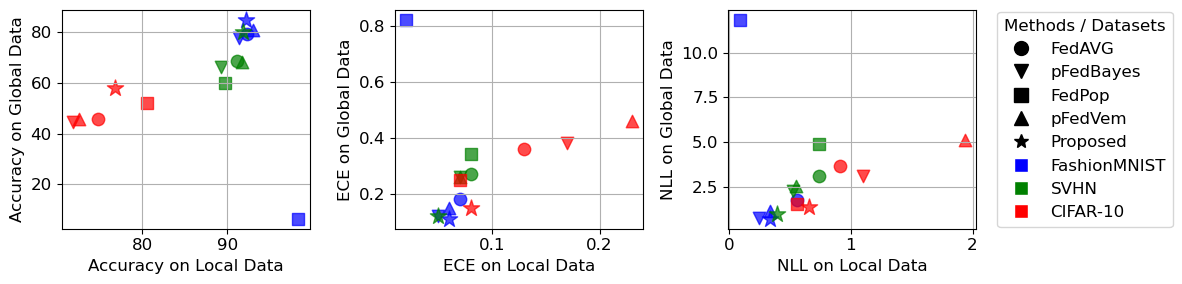

In [7]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 12})


# Original data
acc_local = {
    'FedAVG': [92.28, 91.17, 74.80],
    'pFedBayes': [91.42, 89.27, 71.84],
    'FedPop': [98.35, 89.77, 80.51],
    'pFedVem': [93.00, 91.69, 72.61],
    'Proposed': [92.22, 91.87, 76.82],
}
acc_global = {
    'FedAVG': [79.12, 68.67, 45.89],
    'pFedBayes': [77.51, 66.20, 44.48],
    'FedPop': [6.53, 60, 52.05],
    'pFedVem': [80.74, 67.92, 45.88],
    'Proposed': [84.61, 79.87, 57.75],
}


ece_local = {
    'FedAVG': [0.07, 0.08, 0.13 ],
    'pFedBayes': [0.05, 0.07, 0.17],
    'FedPop': [0.02,  0.08, 0.07],
    'pFedVem': [0.06, 0.07, 0.23],
    'Proposed': [0.06, 0.05, 0.08],
}
ece_global = {
    'FedAVG': [0.18, 0.27, 0.36],
    'pFedBayes': [0.12, 0.26, 0.38],
    'FedPop': [0.82, 0.34, 0.25],
    'pFedVem': [0.15, 0.26, 0.46],
    'Proposed': [0.11, 0.12, 0.15],
}


nll_local = {
    'FedAVG': [0.56, 0.74, 0.91],
    'pFedBayes': [0.25, 0.53, 1.10],
    'FedPop': [0.09, 0.74, 0.56],
    'pFedVem': [0.34, 0.55, 1.94],
    'Proposed': [0.34, 0.40,  0.66],
}
nll_global = {
    'FedAVG': [1.80, 3.11, 3.65],
    'pFedBayes': [0.78, 2.28, 3.12],
    'FedPop': [11.82, 4.92, 1.54],
    'pFedVem': [1.15, 2.55, 5.15],
    'Proposed': [0.73, 1, 1.38],
}


datasets = ['FashionMNIST', 'SVHN', 'CIFAR-10']
colors = {'FashionMNIST': 'blue', 'SVHN': 'green', 'CIFAR-10': 'red'}
markers = {'FedAVG': 'o', 'pFedBayes': 'v', 'FedPop': 's', 'pFedVem': '^', 'Proposed': '*'}

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=False)

metrics = [
    ('Accuracy', acc_local, acc_global),
    ('ECE', ece_local, ece_global),
    ('NLL', nll_local, nll_global)
]

for ax, (metric_name, local_dict, global_dict) in zip(axes, metrics):
    for i, dataset in enumerate(datasets):
        for method in local_dict:
            x = local_dict[method][i]
            y = global_dict[method][i]
            if x is not None and y is not None:
                ax.scatter(x, y,
                           color=colors[dataset],
                           marker=markers[method],
                           s=150 if method == 'Proposed' else 80, 
                           alpha=0.7)
    ax.set_xlabel(f'{metric_name} on Local Data')
    ax.set_ylabel(f'{metric_name} on Global Data')
    ax.grid(True)
    ax.set_facecolor('none')   # Transparent axes background

    #ax.set_title(metric_name)

# Legends
method_legend = [
    Line2D([0], [0], marker=markers[m], color='black', linestyle='None', label=m, markersize=10)
    for m in markers
]
dataset_legend = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[d], label=d, markersize=10)
    for d in colors
]

# Combine both legends and place them to the right of the last subplot
legend_fig = axes[-1]
leg = legend_fig.legend(handles=method_legend + dataset_legend,
                  title='Methods / Datasets',
                  loc='center left',
                  bbox_to_anchor=(1.05, 0.5))
leg.get_frame().set_facecolor('none')   # fully transparent

plt.tight_layout()
fig.patch.set_alpha(0.0)   # Transparent figure background
plt.savefig("tradeoff_metrics_subplots.pdf", bbox_inches='tight')
plt.show()
